In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib.colors import LogNorm
from scipy.integrate import simps
from time import time

Populating the interactive namespace from numpy and matplotlib


In [3]:
from matplotlib.colors import LogNorm, SymLogNorm

In [4]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d


In [5]:
data = pd.read_csv('The_Tax_Burden_on_Tobacco__1970-2017.csv')


In [6]:
# states = data['LocationDesc'].unique()
statesid = data['LocationAbbr'].unique()
sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']

ils, sil = {}, {}
for i in range(len(statesid)):
    ils[i] = statesid[i]
    sil[statesid[i]] = i
    

In [7]:
data['SubMeasureDesc'].unique();

In [8]:
sales = data[data['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
costs = data[data['SubMeasureDesc'] == 'Average Cost per pack ']

# Setup

In [9]:
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')

nyears = years.size
i1 = 18
yearspred =  years[i1:]
yy = years.size


In [10]:
statesales = {}
statecosts = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    statesales[s] = sales[loc]['Data_Value'].values.astype('float32')
    loc = costs['LocationAbbr'] == s
    statecosts[s] = costs[loc]['Data_Value'].values.astype('float32')
# ss = 'CO'
# tmp = statesales['CA'].copy()
# statesales['CA'] = statesales[ss].copy()
# statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)):
    salearray[i] = statesales[ils[i]]
    
costarray = np.zeros((len(ils), years.size))
for i in range(len(statesid)):
    costarray[i] = statecosts[ils[i]]
    
salearrayca = []
for i in range(len(statesid)):
    if ils[i] == 'CA': continue
    else: salearrayca.append(statesales[ils[i]])
salearrayca = np.array(salearrayca)

salearrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: salearrayskip.append(statesales[ils[i]])
salearrayskip = np.array(salearrayskip)

costarrayca = []
for i in range(len(statesid)):
    if ils[i] == 'CA': continue
    else: costarrayca.append(statecosts[ils[i]])
costarrayca = np.array(costarrayca)
costarrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: costarrayskip.append(statecosts[ils[i]])
costarrayskip = np.array(costarrayskip)

casales = statesales['CA']
meansales = salearrayca.mean(axis=0)
cacosts = statecosts['CA']
meancosts = costarrayca.mean(axis=0)

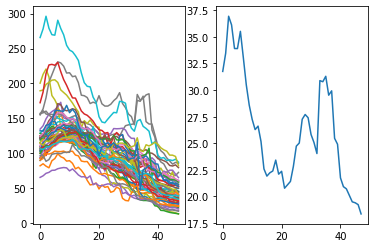

In [11]:
plt.subplot(121)
plt.plot(salearray.T)
plt.subplot(122)
plt.plot(salearray.std(axis=0))


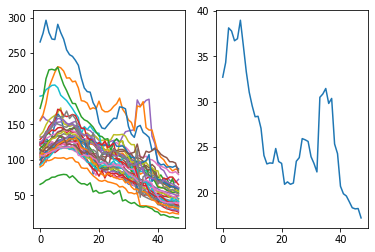

In [12]:
plt.subplot(121)
plt.plot(salearrayskip.T)
plt.subplot(122)
plt.plot(salearrayskip.std(axis=0))


In [13]:
statepinc = {}
for iid in statesid:
    with open('./personal_income/%s.txt'%iid) as f:
        inc = []
        iyears = []
        for line in f.readlines()[1:]:
            iyears.append(float(line.split(',')[0].split('-')[0]))
            inc.append(float(line.split(',')[1]))
        ind = np.where(np.array(iyears)==1970)[0][0]
        statepinc[iid] = np.array(inc[ind:])
        
pincarray = np.zeros((len(ils), years.size))
for i in range(len(statesid)):
    pincarray[i] = statepinc[ils[i]]

pincarrayca = []
for i in range(len(statesid)):
    if ils[i] == 'CA': continue
    else: pincarrayca.append(statepinc[ils[i]])
pincarrayca = np.array(pincarrayca)

capinc = statepinc['CA']
meanpinc = pincarray.mean(axis=0)


In [14]:

synthstates = np.array(['CO', 'CT', 'MO', 'NV', 'UT'])

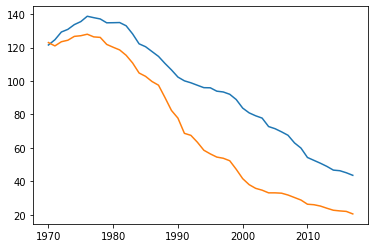

In [15]:
plt.plot(years, salearray.mean(axis=0))
plt.plot(years, statesales['CA'])

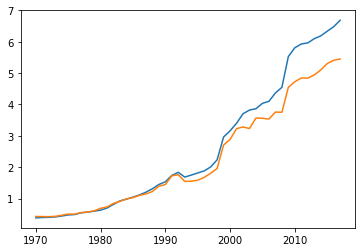

In [16]:
plt.plot(years, costarray.mean(axis=0))
plt.plot(years, statecosts['AL'])

In [17]:
# d1 = statesales['CA']
# d2 = (np.pad(d1, (d1.size//2, d1.size//2), mode='constant', constant_values=0))
# # d2 = (np.pad(d1, (d1.size, d1.size), mode='constant', constant_values=0))

# f1, f2 = np.abs(np.fft.rfft(d1))**2, np.abs(np.fft.rfft(d2))**2
# n1 = np.fft.rfftfreq(d1.size)
# n2 = np.fft.rfftfreq(d2.size)

# plt.plot(n1, f1)
# plt.plot(n2, f2)
# plt.yscale('log')
# plt.show()
# plt.plot(n2, np.interp(n2, n1, f1)/f2)


In [18]:
# ff = np.fft.rfftfreq(casales[:].size)

# # pca = np.fft.rfft(casales-casales.mean())
# pca = np.fft.rfft(casales[:], norm='ortho')
# plt.plot(ff, abs(pca)**2)

# # pall = np.fft.rfft(salearray.mean(axis=1) - salearray.mean())
# pall = np.fft.rfft(salearray[:].mean(axis=1), norm='ortho')
# plt.plot(ff, abs(pall)**2)

# plt.yscale('log')

# Functions

In [19]:
def psfunc(x, x2=None, real=True, ortho=True):

    if ortho: norm='ortho'
    else: norm=None
    if x2 is None: x2 = x.copy()
    if real: 
        xc, xc2 = np.fft.rfft(x, norm=norm), np.fft.rfft(x2, norm=norm)
    else:
        xc, xc2 = np.fft.fft(x, norm=norm), np.fft.fft(x2, norm=norm)
    ps = (xc * xc2.conj()).real
    return ps

def DFT(x, real=False, matrix=False, ortho=True, inv=False):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    Minv = M.conj().T/N
    if ortho: 
        M /= np.sqrt(N)
        Minv *= np.sqrt(N)
    if matrix: 
        if inv: return Minv
        else: return M
    fft = np.dot(M, x)
    if real: fft = fft[:N//2+1]
    return fft

## Check Parsevals theorem here

white = np.random.normal(0, 5, 10000)
print(white.std()**2)
# whitec = np.fft.rfft(white, norm='ortho')

whitepk = psfunc(white, ortho=True)
ffc = np.fft.rfftfreq(white.size)
print((np.trapz(whitepk, ffc)), (np.trapz(whitepk, ffc)/whitepk.size))

whitepk = psfunc(white, real=False, ortho=True)
ffc = np.fft.fftfreq(white.size)
ffc1 = np.concatenate([ffc[ffc.size//2:] , ffc[:ffc.size//2]])
whitepk1 = np.concatenate([whitepk[ffc.size//2:] , whitepk[:ffc.size//2]])
print((np.trapz(whitepk1, ffc1)), (np.trapz(whitepk1, ffc1)/whitepk1.size))


24.51889860627274
12.261186516160327 0.002451746953841297
24.520224856591064 0.0024520224856591066


In [20]:
def getf(padl, padr, real=True, yy=years.size):
    return np.fft.rfftfreq(padl+padr+yy)

def setupdata(salearrayca, casales, padl, padr, al=1., norm=None, trans=None):
    '''returns xp, means, pk, pkca'''
    d = np.pad(salearrayca.copy(), [(0, 0), (padl, padr)], mode='constant', constant_values=0)
    means = d.mean(axis=0)*al
#     std = d.mean(axis=0)*al
    xp = d - means
    std = xp.std(axis=0)
    std[std == 0] = 1
#     if norm is 'mean': xp /= means
#     elif norm is 'std': xp /= std
#     if trans is not None: xp = trans(xp)
    pk = []
    for i in range(xp.shape[0]): pk.append(psfunc(xp[i]))
    pk = np.array(pk)

    if padr: pkca = psfunc(np.pad(casales-means[padl:-padr], (padl, padr), mode='constant', constant_values=0))
    else: pkca = psfunc(np.pad(casales-means[padl:], (padl, padr), mode='constant', constant_values=0))
    if norm is 'std':return xp, means, pk, pkca, std
    else: return xp, means, pk, pkca
    
def pred(p, means, prior=False, norm=None):
    u, v = p[:p.size//2], p[p.size//2:]
    s = u + 1j*v
    x = np.fft.irfft(s, norm='ortho')
    if norm is not None: x*= norm
    x += means
    if prior: 
        ps = abs(s)**2
        return x, ps
    else: return x


def chisq(p, means, casales, priork, padl, sigma=1, i1=18, verbose=False, norm=None):
    x, ps = pred(p, means, prior=True, norm=norm)
    res = (x[padl:padl+i1] - casales[:i1])**2 / sigma**2
    prior = ps/priork 
    if verbose: print(sum(res), sum(prior))
    return sum(res) + sum(prior)




In [21]:
def getcov(ps, padl, padr, n0=0.01, ninf=1e10, real=True):
    if real: psf = np.concatenate([ps, ps[1:-1][::-1]])
    else: psf = ps.copy()
    invsnoisek = np.linalg.inv(np.diag(psf))

    ndiag = np.ones_like(psf)*n0
    # ndiag[padl+i1:] = xp[:, padl+i1:].std(axis=0)**2
    # if padr != 0: ndiag[-padr:] = 1e10
    ndiag[padl+i1:] = ninf

    noise = np.diag(ndiag)
    invnoise = np.linalg.inv(noise)
    ftmatrix = DFT(psf*0, matrix=True)
    ftmatrixdag = DFT(psf*0, matrix=True, inv=True)
    rtnr = np.dot(ftmatrixdag, np.dot(invnoise, ftmatrix))
    d = np.linalg.inv(invsnoisek + rtnr) 
    cov = np.dot(ftmatrix, np.dot(d, ftmatrixdag)).real
    return cov       

In [22]:
# def sampleps(ffpad, ff, pk, n=100,  seed=100):
#     ipk = interp1d(ff, pk)
# #     ipk = lambda x: np.interp(x, ff, pk)
    
#     xxs, xxpad = [], []
#     ps, pspad = [], []
#     np.random.seed(seed)
    
#     for i in range(n):
#         uu = np.random.normal(scale=(ipk(ffpad)/2)**0.5)
#         vv = np.random.normal(scale=(ipk(ffpad)/2)**0.5)
            
#         xx = np.fft.irfft(uu+1j*vv, norm='ortho')
#         xxp = np.zeros_like(xx)
#         if padr: xxp[padl:-padr] = xx[padl:-padr]
#         else: xxp[padl:] = xx[padl:]
#         xxs.append(xx)
#         xxpad.append(xxp)
#         ps.append(psfunc(xxs[-1]))
#         pspad.append(psfunc(xxpad[-1]))
#     xxs, xxpad = np.array(xxs), np.array(xxpad)
#     ps, pspad = np.array(ps), np.array(pspad)
#     return xxs, xxpad, ps, pspad    


# def gettf(ffpad, ff, pkm):
#     xxs, xxpad, ps, pspad = sampleps(ffpad, ff, pkm)
#     tf = pspad.T.mean(axis=1)/ps.T.mean(axis=1)
#     return tf

# def gettfprior(padl, padr, n=2000, samples=False):

#     ff = np.fft.rfftfreq(yy)
#     ffpad = np.fft.rfftfreq(yy + padl + padr)

#     xp = salearray - salearray.mean(axis=0)
#     pkm = (np.abs(np.fft.rfft(xp, axis=1, norm='ortho'))**2).mean(axis=0)
#     # dd = salearray[5]
#     # # means = salearray[:,5].mean()*1
#     # means = salearray.mean(axis=0)
#     # xp = dd - means
#     # pkm = (np.abs(np.fft.rfft(xp,  norm='ortho'))**2)

#     return gettf (ffpad, ff, pkm)


def sampleps(ff, pk, n=100,  seed=100):
    ipk = interp1d(ff, pk)
    xxs, ps = [], []
    np.random.seed(seed)
    
    for i in range(n):
        uu = np.random.normal(scale=(ipk(ff)/2)**0.5)
        vv = np.random.normal(scale=(ipk(ff)/2)**0.5)
            
        xx = np.fft.irfft(uu+1j*vv, norm='ortho')
        xxs.append(xx)
        ps.append(psfunc(xxs[-1]))
    xxs, ps = np.array(xxs), np.array(ps)
    return xxs, ps


def getpadded(padl, padr, xxs):
    xxpad = np.zeros_like(xxs)
    pspad = []
    if padr: xxpad[:, padl:-padr] = xxs[:, padl:-padr]
    else: xxpad[:, padl:] = xxs[:, padl:]
    for i in range(xxpad.shape[0]): pspad.append(psfunc(xxpad[i]))
    pspad = np.array(pspad)
    return xxpad, pspad
    
def gettf(padl, padr, ff, pk, real=True, ny=yy, samples=False, seed=100):

    ffpad = np.fft.rfftfreq(ny + padl + padr)
    ppad = interp1d(ff, pk)(ffpad)
    
    xxs, ps = sampleps(ffpad, ppad, seed=seed)
#     xxpad = np.zeros_like(xxs)
#     pspad = np.zeros_like(ps)
#     if padr: xxpad[:, padl:-padr] = xxs[:, padl:-padr]
#     else: xxpad[:, padl:] = xxs[:, padl:]

#     for i in range(xxpad.shape[0]): pspad[i] = psfunc(xxpad[i])
    xxpad, pspad = getpadded(padl, padr, xxs)
    tf = pspad.T.mean(axis=1)/ps.T.mean(axis=1)
    
    if samples: return tf, [[xxs, ps], [xxpad, pspad]]
    else: return tf


def gettfprior(data1, padl, padr, n=2000, samples=False, seed=100, al=1.0, data2=None, trans=None):

    yy = years.size
    ff = np.fft.rfftfreq(yy)
    xp = data1 - data1.mean(axis=0)*al
    if data2 is not None: xp2 = data2 - data2.mean(axis=0)*al
    else: xp2 = xp
    if trans is not None:
        xp = trans(xp)
        xp2 = trans(xp2)
    p1 =  np.fft.rfft(xp, axis=1, norm='ortho')
    p2 =  np.fft.rfft(xp2, axis=1, norm='ortho')
    pkm = (p1*p2.conj()).mean(axis=0).real
#     pkm = (np.abs(np.fft.rfft(xp, axis=1, norm='ortho'))**2).mean(axis=0)
    return gettf (padl, padr, ff, pkm, real=True, ny=yy, samples=samples, seed=seed)
    

# Predict

In [23]:
# padl, padr = years.size//2, years.size//2
# padl, padr = years.size, years.size
padl, padr = 0, 0
xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr)
pkm = pk.mean(axis=0)

#########

p0 = np.ones(pkm.size*2)
# pp = minimize(tomin, p0, method='Nelder-Mead', options={'maxfev':1000}).x
tomin = lambda p: chisq(p, means, casales, pkm, padl)
pp = minimize(tomin, p0).x
capred, caps = pred(pp, means, prior=True)


Text(0.5, 0, 'Year')

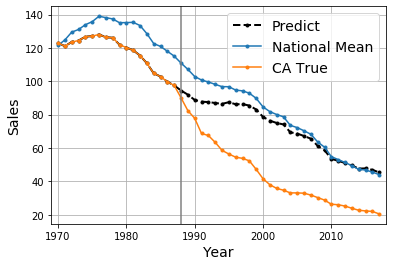

In [24]:
yearspad = np.pad(years, (padl, padr), mode='linear_ramp', end_values=(years[0]-padl, years[-1]+padr))

plt.plot(yearspad, capred ,'k--', lw=2, marker='.', label='Predict')
plt.plot(years, meansales, marker='.', label='National Mean')
plt.plot(years, casales, marker='.', label='CA True')
plt.axvline(years[i1], color='gray')
plt.xlim(years[0]-1, years[-1]+1)
plt.grid(which='both')
plt.legend(fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Year', fontsize=14)


In [25]:
capred[np.where(yearspad==2000)[0][0]]- casales[np.where(years==2000)[0][0]]

37.040187393793644

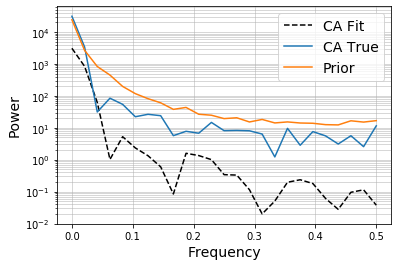

In [26]:
ff = getf(padl, padr)
plt.plot(ff, caps, 'k--', label='CA Fit')
# plt.plot(np.fft.rfftfreq(casales.size), psfunc(casales), label='CA unpad')
plt.plot(ff, pkca, label='CA True')
# plt.plot(np.fft.rfftfreq(casales.size), psf(xp[:, padl:-padr].mean(axis=0)), label='Nat-mean unpad')
plt.plot(ff, pkm, label='Prior')
plt.yscale('log')
plt.ylabel('Power', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.legend( fontsize=14)
plt.grid(which='both', lw=0.5)

# Error bar

In [470]:
for padl, padr in [[0, 0], [0, 10], [10, 10], [yy//2, yy//2], [yy, yy]]:
    
    xp, means, pk, pkca = setupdata(padl, padr)
    pkm = pk.mean(axis=0)

    p0 = np.ones(pkm.size*2)
    tomin = lambda p: chisq(p, means, casales, pkm, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)
    
    cov = getcov(pkm, padl, padr)
    err = cov.diagonal()**0.5
    
    if padr: plt.plot(err[padl:-padr])
    else: plt.plot(err[padl:])
plt.grid()

TypeError: setupdata() missing 2 required positional arguments: 'padl' and 'padr'

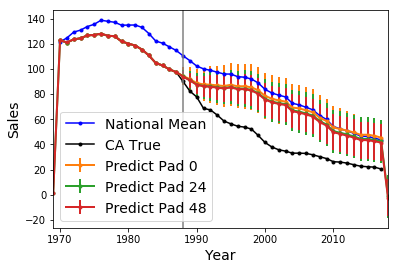

In [20]:
ii = 0
for padl, padr in [[0, 0], [yy//2, yy//2], [yy, yy]]:
    ii +=1 
    xp, means, pk, pkca = setupdata(padl, padr)
    pkm = pk.mean(axis=0)

    p0 = np.ones(pkm.size*2)
    tomin = lambda p: chisq(p, means, casales, pkm, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)
    
    cov = getcov(pkm, padl, padr)
    err = cov.diagonal()**0.5
    
#     if padr: plt.plot(err[padl:-padr])
#     else: plt.plot(err[padl:])

    yearspad = np.pad(years, (padl, padr), mode='linear_ramp', end_values=(years[0]-padl, years[-1]+padr))
    plt.errorbar(yearspad, capred, yerr=err, color='C%d'%ii, lw=2, marker='.', label='Predict Pad %d'%padl)

plt.plot(years, meansales, color='b', marker='.', label='National Mean')
plt.plot(years, casales, color='k', marker='.', label='CA True')
plt.axvline(years[i1], color='gray')
plt.xlim(years[0]-1, years[-1]+1)
plt.grid(which='both')
plt.legend(fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Year', fontsize=14)

plt.grid()

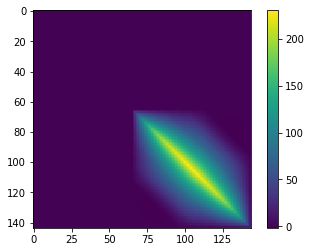

In [21]:
# plt.imshow((1e-15+cov)**0.5)
plt.imshow(cov)
plt.colorbar()

# Cross correlation

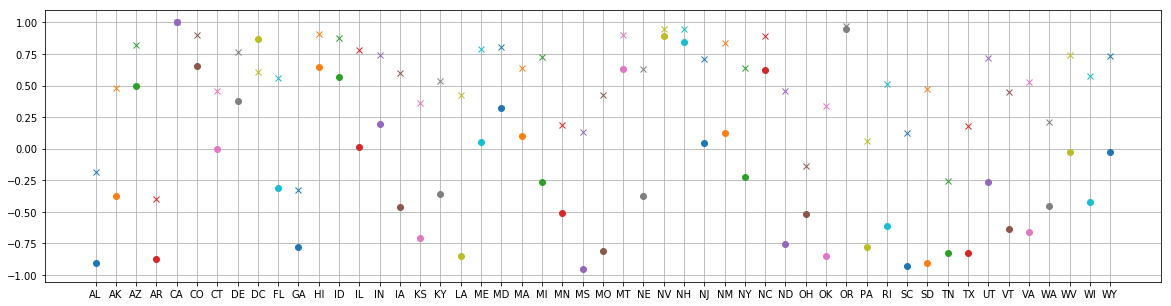

In [54]:
plt.figure(figsize = (20, 5))
cc = []
cc2 = []
for ii in ils:
    cc.append(np.corrcoef(statesales[ils[ii]][:i1]-meansales[:i1], statesales['CA'][:i1]-meansales[:i1])[0, 1])
    cc2.append(np.corrcoef(statesales[ils[ii]][:i1], statesales['CA'][:i1])[0, 1])
    plt.plot(ii, cc[-1], 'C%do'%(ii%10))
    plt.plot(ii, cc2[-1], 'C%dx'%(ii%10))
cc, cc2 = np.array(cc), np.array(cc2)
plt.grid(which='both')
xticks([ii for ii in ils], [ils[ii] for ii in ils])
plt.show()
ccdata = cc.copy()




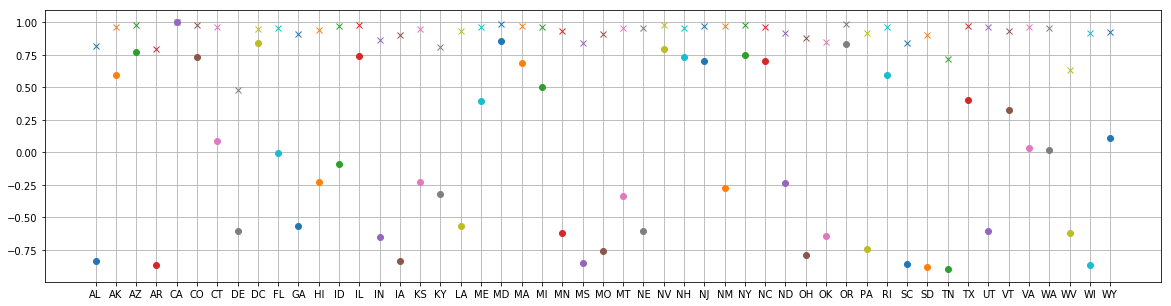

In [128]:
plt.figure(figsize = (20, 5))
cc = []
cc2 = []
for ii in ils:
    cc.append(np.corrcoef(statesales[ils[ii]][:]-meansales[:], statesales['CA'][:]-meansales[:])[0, 1])
    cc2.append(np.corrcoef(statesales[ils[ii]][:], statesales['CA'][:])[0, 1])
    plt.plot(ii, cc[-1], 'C%do'%(ii%10))
    plt.plot(ii, cc2[-1], 'C%dx'%(ii%10))
cc, cc2 = np.array(cc), np.array(cc2)
plt.grid(which='both')
xticks([ii for ii in ils], [ils[ii] for ii in ils])
plt.show()
ccdata2 = cc.copy()

In [57]:
cc.mean()

-0.17319343162467

(array([5., 7., 2., 3., 2., 5., 2., 3., 0., 4., 3., 2., 0., 2., 1., 1., 4.,
        0., 3., 2.]),
 array([-0.9555422 , -0.85776509, -0.75998798, -0.66221087, -0.56443376,
        -0.46665665, -0.36887954, -0.27110243, -0.17332532, -0.07554821,
         0.0222289 ,  0.12000601,  0.21778312,  0.31556023,  0.41333734,
         0.51111445,  0.60889156,  0.70666867,  0.80444578,  0.90222289,
         1.        ]),
 <a list of 20 Patch objects>)

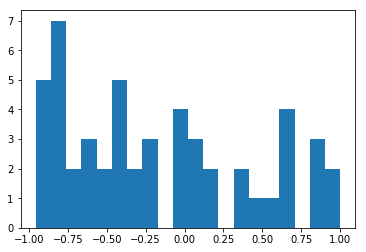

In [59]:
cc = np.array(cc)
plt.hist(cc,bins=20)


In [60]:
# plt.figure(figsize = (20, 5))
# for ii in ils:
#     plt.plot(ii, np.corrcoef(statesales[ils[ii]]-meansales, np.pad(statesales['CA']-meansales, 12, mode='wrap')[:means.size])[0, 1], 'C%do'%(ii%10))
#     plt.plot(ii, np.corrcoef(statesales[ils[ii]], np.pad(statesales['CA'], 12, mode='wrap')[:means.size])[0, 1], 'C%dx'%(ii%10))
# plt.grid(which='both')
# xticks([ii for ii in ils], [ils[ii] for ii in ils])
# plt.show()

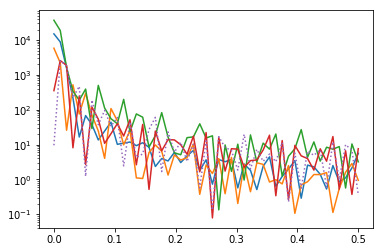

In [134]:
padl, padr = years.size//2, years.size//2
# padl, padr = years.size, years.size
# padl, padr = 0, 0

yearspad = np.pad(years, (padl, padr), mode='linear_ramp', end_values=(years[0]-padl, years[-1]+padr))
capad = np.pad(casales, (padl, padr), mode='constant', constant_values=0)
ff = np.fft.rfftfreq(yearspad.size)

xp = []
for i, iss in enumerate(statesid):
    if iss == 'CA': continue
    else: 
        d = statesales[iss]
        xp.append((np.pad(d, (padl, padr), mode='constant', constant_values=0)))
xp = np.array(xp)
means = xp.mean(axis=0) 
xp -= means
capad -= means

pk = np.array([psfunc(xp[i]) for i in range(xp.shape[0])])
pkm = pk.mean(axis=0)

pkca = psfunc(capad)

pkxca = np.array([psfunc(xp[i], capad) for i in range(xp.shape[0])])


for ii in [0, 5, 10, 23]:
    plt.plot(ff, pk[ii])
plt.plot(ff, pkca, ':')
# plt.plot((pkca/pk[ii])**0.5)
plt.yscale('log')
plt.show()

for ii in [5]:
    plt.plot(ff, pkxca[ii]/(pkca*pk[ii])**0.5)
# plt.plot((pkca/pk[ii])**0.5)
# plt.yscale('log')
plt.show()

In [137]:
# for i in ils:
#     print( np.corrcoef(xp[i], capad)[0, 1])
# # np.correlate(means, capad, mode='same')**2/np.correlate(means, means, mode='same')/np.correlate(capad, capad, mode='same')

# simulate window

(1, 100000.0)

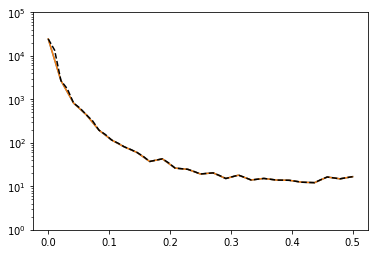

In [256]:
xp = salearray - salearray.mean(axis=0)
pkm = (np.abs(np.fft.rfft(xp, axis=1, norm='ortho'))**2).mean(axis=0)

# dd = salearray[5]
# # means = salearray[:,5].mean()*1
# means = salearray.mean(axis=0)
# xp = dd - means
# pkm = (np.abs(np.fft.rfft(xp,  norm='ortho'))**2)


ff = np.fft.rfftfreq(yy)
ipk = interp1d(ff, pkm)
plt.plot(ff, pkm)
plt.plot(ff, ipk(ff))

padl, padr = yy//2, yy//2
# padl, padr = yy*10, yy*10
ffpad = np.fft.rfftfreq(yy + padl + padr)
plt.plot(ffpad, ipk(ffpad), 'k--')

plt.yscale('log')
plt.ylim(1, 1e5)

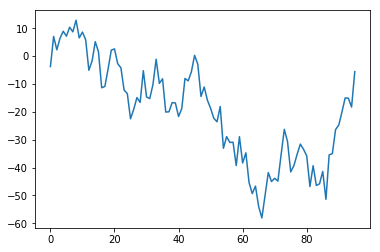

In [257]:
xxs, ps = sampleps(ffpad, ipk(ffpad))

tf, tmp = gettf(padl, padr, ff, pkm, samples=True)
xxs, ps = tmp[0]
xxpad, pspad = tmp[1]
plt.plot(xxs[0])
# try: plt.plot(xp[::10].T, 'k')
# except:  plt.plot(xp, 'k')


In [254]:
plt.plot(ffpad, ps.T.mean(axis=1), label='Mean')
plt.plot(ffpad, ps.T[:, ::10], alpha=0.5)
# plt.plot(ff, psfunc(xp), label='Truth')
plt.plot(ff, ipk(ff), 'k--', label='Truth')

# plt.plot(xp[:, ::10])
plt.yscale('log')
plt.ylim(1, 1e5)
plt.legend()

NameError: name 'ps' is not defined

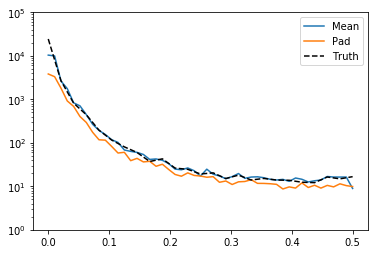

In [66]:
plt.plot(ffpad, ps.T.mean(axis=1), label='Mean')
plt.plot(ffpad, pspad.T.mean(axis=1), label='Pad')
# plt.plot(ff, psfunc(xp), label='Truth')
plt.plot(ff, ipk(ff), 'k--', label='Truth')

# plt.plot(xp[:, ::10])
plt.yscale('log')
plt.ylim(1, 1e5)
plt.legend()

(0, 2)

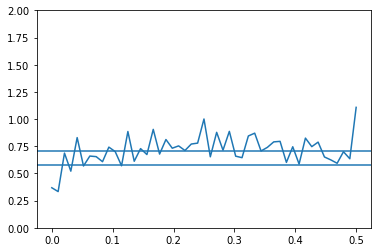

In [67]:
plt.plot(ffpad, pspad.T.mean(axis=1)/ps.T.mean(axis=1))
plt.axhline(1/np.sqrt(2))
plt.axhline(1/np.sqrt(3))
plt.ylim(0, 2)

### For some smooth 

In [79]:
# # padl, padr = years.size//2, years.size//2
# padl, padr = years.size, years.size
# # padl, padr = 0, 0

# yearspad = np.pad(years, (padl, padr), mode='linear_ramp', end_values=(years[0]-padl, years[-1]+padr))
# yx = np.arange(padl, padl+nyears)
# ypad = np.arange(0, padl+nyears+padr)
# ff = np.fft.rfftfreq(yearspad.size)
# f0 = np.fft.rfftfreq(years.size)

# tf = []
# deg = 7
# for i in np.random.randint(0, 50, 5):
#     iss = ils[i]
#     d = statesales[iss] - salearray.mean(axis=0)
#     fx = np.polyfit(yx, d, deg=deg)[::-1]
#     basis = np.array([ypad**i for i in range( deg+1)])
#     fake = (basis.T*fx).sum(axis=1)
# #     fakepad = (np.pad(fake, (padl, padr), mode='constant', constant_values=0))
#     fakepad = fake.copy()
#     fakepad[:padl] = 0
#     fakepad[-padr:] = 0

#     plt.plot(yx, d, 'C%d'%(i%8))
#     plt.plot(ypad, fake, 'C%d--'%(i%8))
    
#     tf.append([psfunc(fake), psfunc(fakepad)])    

    
# ###Plot    
# # tfs = np.array([tf[i][2] for i in range(len(tf))])

# for i in range(4):
#     lbl0, lbl1 = None, None
#     if i == 0: lbl0, lbl1 = 'No pad', 'Zero pad'
# #     plt.plot(f0, tf[i][0], 'C%d'%i, label=lbl0)
#     plt.plot(ff, tf[i][0], 'C%d'%i, label=lbl0)
#     plt.plot(ff, tf[i][1], 'C%d--'%i, label=lbl1, lw=2)
# plt.yscale('log')
# plt.legend()
# #     plt.ylim(.1, 3)



# Correct for window

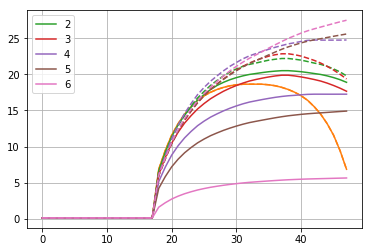

In [22]:
ii = 0
for padl, padr in [[0, 0], [0, 10], [10, 10], [yy//2, yy//2], [yy, yy], [10*yy, 10*yy]]:
    ii += 1
    xp, means, pk, pkca = setupdata(padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(padl, padr, n=50000)
    pktrue = pkm/tfpad
    
    cov = getcov(pkm, padl, padr)
    err = cov.diagonal()**0.5    
    if padr: plt.plot(err[padl:-padr], 'C%d'%ii, label=ii)
    else: plt.plot(err[padl:], 'C%d-'%ii)
    
    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5    
    if padr: plt.plot(err[padl:-padr], 'C%d--'%ii)
    else: plt.plot(err[padl:], 'C%d--'%ii)
    
#     if padr: plt.plot(err[padl:-padr])
#     else: plt.plot(err[padl:])
plt.legend()
plt.grid()

[]

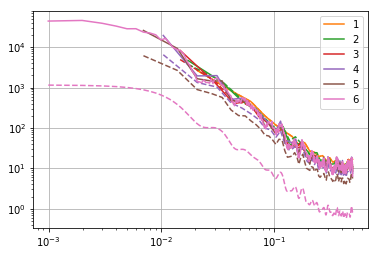

In [23]:
ii = 0
for padl, padr in [[0, 0], [0, 10], [10, 10], [yy//2, yy//2], [yy, yy], [10*yy, 10*yy]]:
    ii += 1
    xp, means, pk, pkca = setupdata(padl, padr)
    pkm = pk.mean(axis=0)
#     ff  = getf(0, 0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(padl, padr, n=50000)
    pktrue = pkm/tfpad
    plt.plot(ffpad[1:], pktrue[1:], 'C%d-'%ii, label=ii)
    plt.plot(ffpad[1:], pkm[1:], 'C%d--'%ii)
plt.legend()
plt.grid()
plt.loglog()

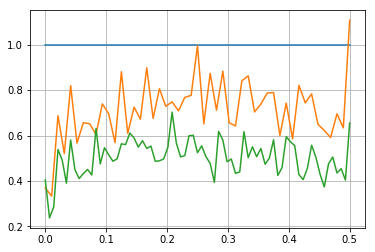

In [24]:
# for padl, padr in [[0, 0], [0, 10], [10, 10], [yy//2, yy//2], [yy, yy]]:
    
for padl, padr in [[0, 0],  [yy//2, yy//2], [yy, yy]]:
    
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(padl, padr)
    plt.plot(ffpad, tfpad)

plt.grid()

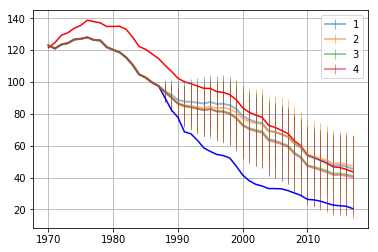

In [25]:
ii = 0 
preds = []
for padl, padr in [[0, 0],  [10, 10], [yy//2, yy//2], [yy, yy]]:
    ii +=1
    xp, means, pk, pkca = setupdata(padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(padl, padr)
    pktrue = pkm/tfpad
    
    p0 = np.ones(pkm.size*2)
    tomin = lambda p: chisq(p, means, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)
        
    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    preds.append([capred, err])
#     if padr: plt.plot(err[padl:-padr])
#     else: plt.plot(err[padl:])
    if padr: plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1, label=ii)
    else: plt.errorbar(years, capred[padl:], err[padl:], alpha=0.5, lw=2, elinewidth=1, label=ii)

plt.plot(years, casales, 'b-')
plt.plot(years, meansales, 'r-')
plt.grid()
plt.legend()
# plt.xlim(years[i1], years[-1])
# plt.ylim(20, 100)

In [26]:
padl, padr = yy*10, yy*10

xp, means, pk, pkca = setupdata(padl, padr)
pkm = pk.mean(axis=0)
ffpad  = getf(padl, padr)
tfpad = gettfprior(padl, padr)
pktrue = pkm/tfpad



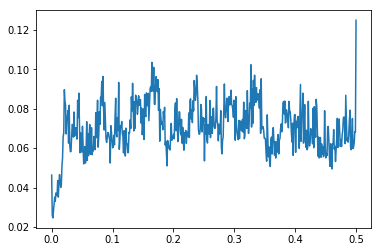

In [27]:
plt.plot(ffpad, tfpad)

## Crosscorrelations 2 

In [374]:
# def getf(padl, padr, real=True, yy=years.size):
#     return np.fft.rfftfreq(padl+padr+yy)

# def setupdata(padl, padr):
#     '''returns xp, means, pk, pkca'''
#     d = np.pad(salearrayca.copy(), [(0, 0), (padl, padr)], mode='constant', constant_values=0)
#     means = d.mean(axis=0)
#     xp = d - means
#     pkm = (np.abs(np.fft.rfft(xp, axis=0, norm='ortho'))**2).mean(axis=1)

#     pk = []
#     for i in range(xp.shape[0]): pk.append(psfunc(xp[i]))
#     pk = np.array(pk)
#     pkm = pk.mean(axis=0)

#     if padr: pkca = psfunc(np.pad(casales-means[padl:-padr], (padl, padr), mode='constant', constant_values=0))
#     else: pkca = psfunc(np.pad(casales-means[padl:], (padl, padr), mode='constant', constant_values=0))
#     return xp, means, pk, pkca
    
# def pred(p, means, prior=False):
#     u, v = p[:p.size//2], p[p.size//2:]
#     s = u + 1j*v
#     x = np.fft.irfft(s, norm='ortho') + means
#     if prior: 
#         ps = abs(s)**2
#         return x, ps
#     else: return x


# def chisq(p, means, casales, priork, padl, sigma=1, i1=18):
#     x, ps = pred(p, means, prior=True)
#     sigma = 1
#     res = (x[padl:padl+i1] - casales[:i1])**2 / sigma**2
#     prior = ps/priork 
#     return sum(res) + sum(prior)




# def sampleps(ff, pk, n=100,  seed=100):
#     ipk = interp1d(ff, pk)
#     xxs, ps = [], []
#     np.random.seed(seed)
    
#     for i in range(n):
#         uu = np.random.normal(scale=(ipk(ff)/2)**0.5)
#         vv = np.random.normal(scale=(ipk(ff)/2)**0.5)
            
#         xx = np.fft.irfft(uu+1j*vv, norm='ortho')
#         xxs.append(xx)
#         ps.append(psfunc(xxs[-1]))
#     xxs, ps = np.array(xxs), np.array(ps)
#     return xxs, ps


# def gettf(padl, padr, ff, pk, real=True, ny=yy, samples=False):

#     print(ny, padl, padr)
#     ffpad = np.fft.rfftfreq(ny + padl + padr)
#     ppad = interp1d(ff, pk)(ffpad)
#     print(ffpad.shape, ppad.shape)
    
#     xxs, ps = sampleps(ffpad, ppad)
#     xxpad = np.zeros_like(xxs)
#     pspad = np.zeros_like(ps)
#     print(xxs.shape, ps.shape)
#     if padr: xxpad[:, padl:-padr] = xxs[:, padl:-padr]
#     else: xxpad[:, padl:] = xxs[:, padl:]
    
#     for i in range(xxpad.shape[0]): pspad[i] = psfunc(xxpad[i])
#     tf = pspad.T.mean(axis=1)/ps.T.mean(axis=1)
    
#     if samples: return tf, [[xxs, ps], [xxpad, pspad]]
#     else: return tf


# def gettfprior(padl, padr, n=2000, samples=False):

#     ff = np.fft.rfftfreq(yy)
#     xp = salearrayca - salearrayca.mean(axis=0)
#     pkm = (np.abs(np.fft.rfft(xp, axis=1, norm='ortho'))**2).mean(axis=0)
#     return gettf (padl, padr, ff, pkm, samples=samples)
    
    

# # # def sampleps(ffpad, ff, pk, n=100,  seed=100):
# # #     ipk = interp1d(ff, pk)
# # # #     ipk = lambda x: np.interp(x, ff, pk)
    
# # #     xxs, xxpad = [], []
# # #     ps, pspad = [], []
# # #     np.random.seed(seed)
    
# # #     print(padl, padr)
# # #     for i in range(n):
# # #         uu = np.random.normal(scale=(ipk(ffpad)/2)**0.5)
# # #         vv = np.random.normal(scale=(ipk(ffpad)/2)**0.5)
            
# # #         xx = np.fft.irfft(uu+1j*vv, norm='ortho')
# # #         xxp = np.zeros_like(xx)
# # #         if i ==0: print(xxp.shape[0]-padl-padr)
# # #         if padr: xxp[padl:-padr] = xx[padl:-padr]
# # #         else: xxp[padl:] = xx[padl:]
# # #         xxs.append(xx)
# # #         xxpad.append(xxp)
# # #         ps.append(psfunc(xxs[-1]))
# # #         pspad.append(psfunc(xxpad[-1]))
# # #     xxs, xxpad = np.array(xxs), np.array(xxpad)
# # #     ps, pspad = np.array(ps), np.array(pspad)
# # #     return xxs, xxpad, ps, pspad    


# # # def gettf(ffpad, ff, pkm):
# # #     xxs, xxpad, ps, pspad = sampleps(ffpad, ff, pkm)
# # #     tf = pspad.T.mean(axis=1)/ps.T.mean(axis=1)
# # #     return tf, [xxs, xxpad, ps, pspad]


# # # def gettfprior(padl, padr, n=2000, samples=False):

# # #     ff = np.fft.rfftfreq(yy)
# # #     ffpad = np.fft.rfftfreq(yy + padl + padr)
# # #     xp = salearrayca - salearrayca.mean(axis=0)
# # #     pkm = (np.abs(np.fft.rfft(xp, axis=1, norm='ortho'))**2).mean(axis=0)
# # #     if samples: return gettf (ffpad, ff, pkm)
# # #     else: return gettf (ffpad, ff, pkm)[0]


In [55]:
d1, d2 = statesales['CA'] - salearray.mean(axis=0), statesales['AL'] - salearray.mean(axis=0)
# d1, d2 = statesales['CA'] , statesales['AL'] 

p1, p2 = psfunc(d1), psfunc(d2)
# p1[2:] = 0
# p2[2:] = 0
# p1[:5] = 0
# p2[:5] = 0

padl, padr = yy, yy
# padl, padr = yy*2, yy*2
# padl, padr = 1, 1
ff = np.fft.rfftfreq(d1.size)
ffpad = np.fft.rfftfreq(d1.size+padl+padr)
p1pad, p2pad = interp1d(ff, p1)(ffpad), interp1d(ff, p2)(ffpad)


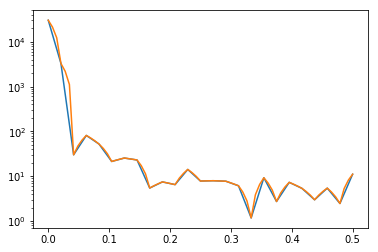

In [51]:
plt.plot(ff, p1)
plt.plot(ffpad, p1pad)
plt.yscale('log')


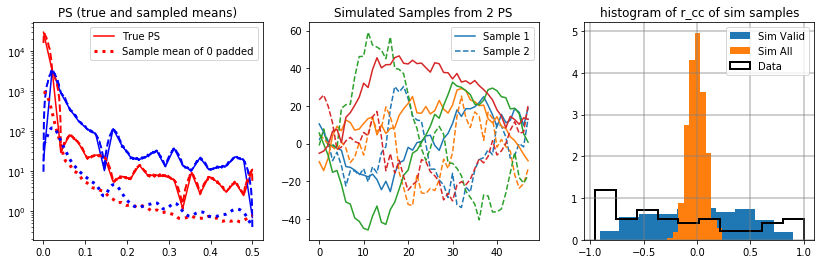

In [71]:
d1, d2 = statesales['CA'] - salearray.mean(axis=0), statesales['AL'] - salearray.mean(axis=0)
# d1, d2 = statesales['CA'] , statesales['AL'] 

p1, p2 = psfunc(d1), psfunc(d2)
# p1[2:] = 0
# p2[2:] = 0
# p1[:5] = 0
# p2[:5] = 0

padl, padr = yy, yy
padl, padr = yy*10, yy*10

ff = np.fft.rfftfreq(d1.size)
ffpad = np.fft.rfftfreq(d1.size+padl+padr)

# t1, t2 = gettf(padl, padr, ff, p1, samples=True, seed=100)[1]
# xx1, xxpad1, ps1, pspad1 = *t1, *t2
# t1, t2 = gettf(padl, padr, ff, p2, samples=True, seed=500)[1]
# xx2, xxpad2, ps2, pspad2 = *t1, *t2

p1pad, p2pad = interp1d(ff, p1)(ffpad), interp1d(ff, p2)(ffpad)

xx1, ps1 = sampleps(ffpad, p1pad, n=1000,  seed=100)
xx2, ps2 = sampleps(ffpad, p2pad, n=1000,  seed=500)
xxpad1, pspad1 = getpadded(padl, padr, xx1)
xxpad2, pspad2 = getpadded(padl, padr, xx2)


#################################################
plt.figure(figsize= (14, 4))

ax = plt.subplot(131)
plt.plot(ff, p1, 'r', label='True PS')
plt.plot(ff, p2, 'b')
plt.plot(ffpad, ps1.mean(axis=0), 'r--',lw=2)
plt.plot(ffpad, ps2.mean(axis=0), 'b--',lw=2)
plt.plot(ffpad, pspad1.mean(axis=0), 'r:', lw=3, label='Sample mean of 0 padded')
plt.plot(ffpad, pspad2.mean(axis=0), 'b:', lw=3)
plt.yscale('log')
plt.legend()
plt.title('PS (true and sampled means)')


ax = plt.subplot(132)
for i in range(4):
    lbl1, lbl2 = None, None
    if i == 0: lbl1, lbl2 = 'Sample 1', 'Sample 2'
    plt.plot(xx1[i, padl:-padr], 'C%d-'%i, label=lbl1)
    plt.plot(xx2[i, padl:-padr], 'C%d--'%i, label=lbl2)
plt.legend()
plt.title('Simulated Samples from 2 PS')

ax = plt.subplot(133)
cc = []
for i in range(xx1.shape[0]): cc.append(np.corrcoef(xx1[i, padl:-padr], xx2[i, padl:-padr])[0, 1])
plt.hist(cc, normed=True, label='Sim Valid')
cc = []
for i in range(xx1.shape[0]): cc.append(np.corrcoef(xx1[i, :], xx2[i, :])[0, 1])
plt.hist(cc, normed=True, label='Sim All')
plt.hist(ccdata, normed=True, histtype='step', lw=2, color='k', label='Data')
plt.grid(which='both', color='gray', lw=1.5, alpha=0.5)

plt.legend()
plt.title('histogram of r_cc of sim samples')
plt.show()

In [76]:
pkm.shape

(25,)

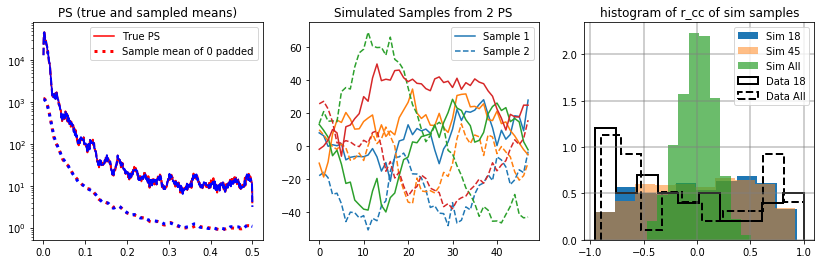

In [135]:
padl, padr = yy*10, yy*10

xp, means, pk, pkca = setupdata(padl, padr)
pkm = pk.mean(axis=0)

tf = gettfprior(padl, padr)

pktrue = pkm/tf

p1, p2 = pktrue.copy(), pktrue.copy()
# p1[2:] = 0
# p2[2:] = 0
# p1[:5] = 0
# p2[:5] = 0


ff = np.fft.rfftfreq(yy+padl+padr)
ffpad = np.fft.rfftfreq(yy+padl+padr)

# t1, t2 = gettf(padl, padr, ff, p1, samples=True, seed=100)[1]
# xx1, xxpad1, ps1, pspad1 = *t1, *t2
# t1, t2 = gettf(padl, padr, ff, p2, samples=True, seed=500)[1]
# xx2, xxpad2, ps2, pspad2 = *t1, *t2

p1pad, p2pad = interp1d(ff, p1)(ffpad), interp1d(ff, p2)(ffpad)

xx1, ps1 = sampleps(ffpad, p1pad, n=1000,  seed=100)
xx2, ps2 = sampleps(ffpad, p2pad, n=1000,  seed=500)
xxpad1, pspad1 = getpadded(padl, padr, xx1)
xxpad2, pspad2 = getpadded(padl, padr, xx2)


#################################################
plt.figure(figsize= (14, 4))

ax = plt.subplot(131)
plt.plot(ff, p1, 'r', label='True PS')
plt.plot(ff, p2, 'b')
plt.plot(ffpad, ps1.mean(axis=0), 'r--',lw=2)
plt.plot(ffpad, ps2.mean(axis=0), 'b--',lw=2)
plt.plot(ffpad, pspad1.mean(axis=0), 'r:', lw=3, label='Sample mean of 0 padded')
plt.plot(ffpad, pspad2.mean(axis=0), 'b:', lw=3)
plt.yscale('log')
plt.legend()
plt.title('PS (true and sampled means)')


ax = plt.subplot(132)
for i in range(4):
    lbl1, lbl2 = None, None
    if i == 0: lbl1, lbl2 = 'Sample 1', 'Sample 2'
    plt.plot(xx1[i, padl:-padr], 'C%d-'%i, label=lbl1)
    plt.plot(xx2[i, padl:-padr], 'C%d--'%i, label=lbl2)
plt.legend()
plt.title('Simulated Samples from 2 PS')

ax = plt.subplot(133)
cc = []
for i in range(xx1.shape[0]): cc.append(np.corrcoef(xx1[i, padl:-padr-i1], xx2[i, padl:-padr-i1])[0, 1])
plt.hist(cc, normed=True, label='Sim 18')
cc = []
for i in range(xx1.shape[0]): cc.append(np.corrcoef(xx1[i, padl:-padr], xx2[i, padl:-padr])[0, 1])
plt.hist(cc, normed=True, label='Sim 45', alpha=0.5)
cc2 = []
for i in range(xx1.shape[0]): cc2.append(np.corrcoef(xx1[i, :], xx2[i, :])[0, 1])
plt.hist(cc2, normed=True, label='Sim All', alpha=0.7)
plt.hist(ccdata, normed=True, histtype='step', lw=2, color='k', label='Data 18')
plt.hist(ccdata2, normed=True, histtype='step', lw=2, color='k', ls="--", label='Data All')
plt.grid(which='both', color='gray', lw=1.5, alpha=0.5)

plt.legend()
plt.title('histogram of r_cc of sim samples')
plt.show()

In [139]:

np.array(cc).max();

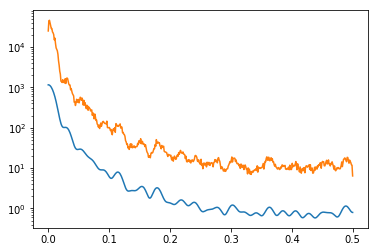

In [113]:
plt.plot(ff, pkm)
plt.plot(ff, pktrue)
plt.yscale('log')

[[1.         0.49313579]
 [0.49313579 1.        ]]


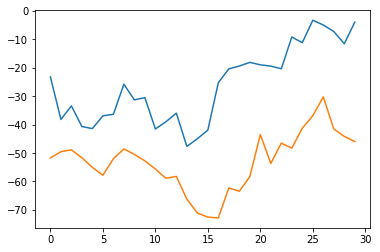

In [134]:
ii = 100
# plt.plot(xx1[ii])
# plt.plot(xxpad1[ii])
# plt.plot(xx1[ii, padl:-padr])
# plt.plot(xx2[ii, padl:-padr])
plt.plot(xx1[ii, padl:-padr-i1])
plt.plot(xx2[ii, padl:-padr-i1])
print(np.corrcoef(xx1[ii, padl:-padr], xx2[ii, padl:-padr]))

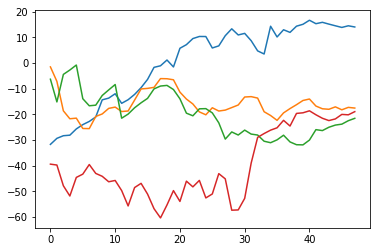

In [125]:
plt.plot(xp[0][padl:-padr])
plt.plot(xp[5][padl:-padr])
plt.plot(xp[2][padl:-padr])
plt.plot(xp[10][padl:-padr])

# put it alltogether

In [26]:
statesales = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

ss = 'CA'
tmp = statesales['CA'].copy() 
statesales['CA'] = statesales[ss].copy()
statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)): salearray[i] = statesales[ils[i]]
    
salearrayca = []
for i in range(len(statesid)):
    if ils[i] == 'CA': continue
    else: salearrayca.append(statesales[ils[i]])
salearrayca = np.array(salearrayca)

i1 = 18
yy = years.size

casales = statesales['CA']
meansales = salearray.mean(axis=0)

Expected difference :  [31.60365211]


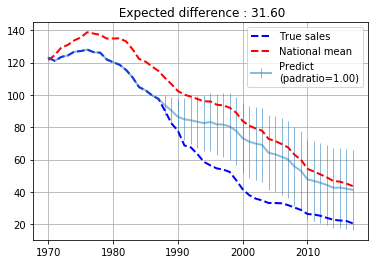

In [27]:
ii = 0 
preds = []
# for padl, padr in [[1, 1],  [10, 10], [yy//2, yy//2], [yy, yy]]:
for padl, padr in [[yy//2, yy//2]]:
    ii +=1
    xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr)
    pktrue = pkm/tfpad
    
    p0 = np.ones(pkm.size*2)
    tomin = lambda p: chisq(p, means, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)
    capredfid = capred.copy()
    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    preds.append([capred, err])

    if padr: plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1, label='Predict\n(padratio=%.2f)'%(2*padl/yy))
    else: plt.errorbar(years, capred[padl:], err[padl:], alpha=0.5, lw=2, elinewidth=1, label=ii)
    print('Expected difference : ', capred[padl:-padr][years==2000] - casales[years==2000])
    plt.title(' Expected difference : %.2f'%(capred[padl:-padr][years==2000] - casales[years==2000]))
    
plt.plot(years, casales, 'b--', lw=2, label='True sales')
plt.plot(years, meansales, 'r--', lw=2, label='National mean')
plt.grid()
plt.legend()

# plt.xlim(years[i1], years[-1])
# plt.ylim(20, 100)

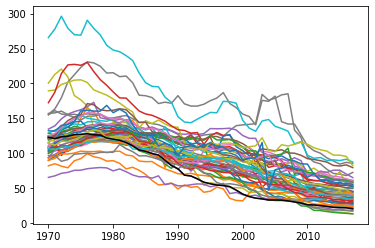

In [28]:
for ii in ils:
    plt.plot(years, statesales[ils[ii]])
plt.plot(years, casales, 'k')


# Significance

In [29]:
meansales[i1:]

array([110.51568559, 106.64509837, 102.35686298, 100.11176427,
        98.93725474,  97.46862711,  96.02548996,  95.9431373 ,
        93.92352953,  93.45294092,  92.06666595,  88.92352953,
        83.8019607 ,  80.93725466,  79.20000001,  77.81960708,
        72.76470551,  71.47451019,  69.60000027,  67.53921554,
        62.98627423,  59.87647049,  54.26470581,  52.53725482,
        50.81764734,  48.92941157,  46.7058825 ,  46.3450981 ,
        45.12156862,  43.59019586])

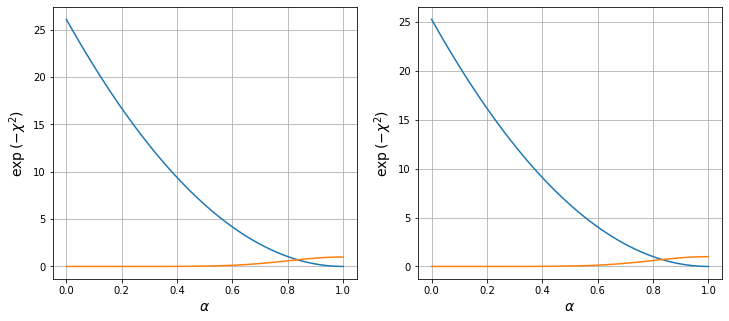

In [28]:


plt.figure(figsize=(12, 5))

ii = 0 
for padl, padr in [[yy//2, yy//2], [yy, yy]]:
# for padl, padr in [[yy//2, yy//2]]:
    ii +=1
    xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr)
    pktrue = pkm/tfpad
    p0 = np.ones(pkm.size*2)

    tomin = lambda p: chisq(p, means, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)

#     cov = getcov(pktrue, padl, padr, ninf=100**2)
    cov = getcov(pktrue, padl, padr, ninf=30**2)
#     cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5

    covpred = cov[padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)


    catrue = casales[i1:]
    mod = lambda al: capred[padl+i1:-padr] + al*(catrue - capred[padl+i1:-padr])

    sig = lambda al: np.dot(np.dot(mod(al)-catrue, icovpred), mod(al)-catrue)
    ax = plt.subplot(1, 2, ii)
    alpha = np.linspace(0, 1)
    plt.plot(alpha, [sig(al) for al in alpha])
    plt.plot(alpha, [np.exp(-sig(al)/2.) for al in alpha])
#     plt.yscale('log')
    plt.grid(which='both')
    plt.xlabel(r'$\alpha$', fontsize=14)
    plt.ylabel(r'${\rm exp}\, (-\chi^2)$', fontsize=14)

In [29]:
# ii = 0 
# preds = []
# als = np.arange(0.3, 1.15, 0.1)
# # for padl, padr in [[yy//2, yy//2], [yy, yy], [2*yy, 2*yy]]:
# for padl, padr in [[yy//2, yy//2]]:
#     ii +=1
#     xp, means, pk, pkca = setupdata(padl, padr)
#     pkm = pk.mean(axis=0)
#     ffpad  = getf(padl, padr)
#     tfpad = gettfprior(padl, padr)
#     pktrue = pkm/tfpad
#     p0 = np.ones(pkm.size*2)
   
    
#     cov = getcov(pktrue, padl, padr)
#     err = cov.diagonal()**0.5
#     alpreds = []
#     for al in als:
#         tomin = lambda p: chisq(p, means*al, casales, pktrue, padl)
#         pp = minimize(tomin, p0).x
#         capred = pred(pp, means*al)
#         alpreds.append([capred, err, cov])
        
#     preds.append(alpreds)
#     if padr: plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1, label='Predict\n(padratio=%.2f)'%(2*padl/yy))
#     else: plt.errorbar(years, capred[padl:], err[padl:], alpha=0.5, lw=2, elinewidth=1, label=ii)
#     print('Expected difference : ', capred[padl:-padr][years==2000] - casales[years==2000])
#     plt.title(' Expected difference : %.2f'%(capred[padl:-padr][years==2000] - casales[years==2000]))
    
# plt.plot(years, casales, 'b--', lw=2, label='True sales')
# plt.plot(years, meansales, 'r--', lw=2, label='National mean')
# plt.grid()
# plt.legend()

# # plt.xlim(years[i1], years[-1])
# # plt.ylim(20, 100)

## 1D analysis

Expected difference :  [39.51659369]


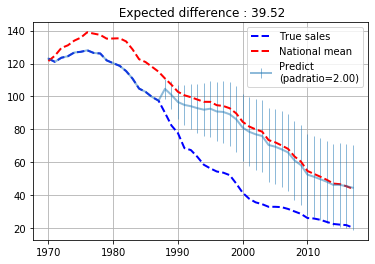

In [30]:
ii = 0 
preds = []
als = np.round(np.arange(0.6, 1.1, 0.02), 2)
ia1 = np.where(als == 1.)[0][0]

# for padl, padr in [[yy//2, yy//2], [yy, yy], [2*yy, 2*yy]]:
for padl, padr in [[yy, yy]]:
    ii +=1
    alpreds = []
    al = 1.
    xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr, al=al)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr, al=al)
    pktrue = pkm/tfpad
    p0 = np.ones(pkm.size*2)

    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    tomin = lambda p: chisq(p, means*al, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    for al in als:
        newmeans = means.copy()
        newmeans[padl+i1:] *= al
        capred = pred(pp, newmeans)
        alpreds.append([capred, err, cov])
        
    preds.append(alpreds)
    if padr: plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1, label='Predict\n(padratio=%.2f)'%(2*padl/yy))
    else: plt.errorbar(years, capred[padl:], err[padl:], alpha=0.5, lw=2, elinewidth=1, label=ii)
    print('Expected difference : ', capred[padl:-padr][years==2000] - casales[years==2000])
    plt.title(' Expected difference : %.2f'%(capred[padl:-padr][years==2000] - casales[years==2000]))
    
plt.plot(years, casales, 'b--', lw=2, label='True sales')
plt.plot(years, meansales, 'r--', lw=2, label='National mean')
plt.grid()
plt.legend()

# plt.xlim(years[i1], years[-1])
# plt.ylim(20, 100)

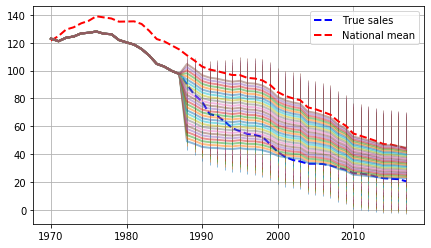

In [31]:
plt.figure(figsize=(7, 4))
nn = 1
plt.subplot(1,nn,1)
for i, j in enumerate(als):
    if i%1 == 0:
        capred, err = preds[0][i][:2]
        plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1)#, label="%.2f"%j)
plt.plot(years, casales, 'b--', lw=2, label='True sales')
plt.plot(years, meansales, 'r--', lw=2, label='National mean')
plt.legend()
plt.grid()



-0.36020869230239594


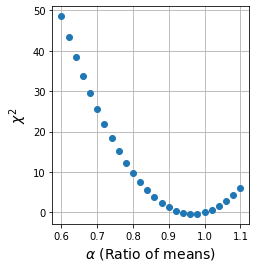

In [32]:
plt.figure(figsize=(12, 4))
nn = 3
plt.subplot(1,nn,1)
padl, padr = yy, yy
chis = []

for i, j in enumerate(als):
    covpred = preds[0][i][-1][padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)
    m = preds[0][i][0][padl+i1:-padr]
    diff = m - casales[i1:]
    chis.append(np.dot(np.dot(diff, icovpred), diff))
chis = np.array(chis)
plt.plot(als, chis-chis[ia1], 'o')
plt.xlabel(r'$\alpha$ (Ratio of means)', fontsize=14)
# plt.ylabel(r'exp (-$\chi^2$)', fontsize=14)
plt.ylabel(r'$\chi^2$', fontsize=14)
# plt.ylim(3, 5.5)
plt.grid()

print((chis-chis[ia1]).min())


## 2D analysis


In [27]:
statesales = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

ss = 'CA'
tmp = statesales['CA'].copy() 
statesales['CA'] = statesales[ss].copy()
statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)): salearray[i] = statesales[ils[i]]
    
salearrayca = []
for i in range(len(statesid)):
    if ils[i] == 'CA': continue
    else: salearrayca.append(statesales[ils[i]])
salearrayca = np.array(salearrayca)

i1 = 18
yy = years.size

casales = statesales['CA']
meansales = salearray.mean(axis=0)

ii = 0 
preds = []

als = np.round(np.arange(0.8, 1.1, 0.001), 3)
bts = np.round(np.arange(0.8, 1.1, 0.001), 3)
# for padl, padr in [[yy//2, yy//2], [yy, yy], [2*yy, 2*yy]]:
for padl, padr in [[yy//2, yy//2]]:
    ii +=1
    alpreds = []
    al = 1.
    xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr, al=al)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr, al=al)
    pktrue = pkm/tfpad
    p0 = np.ones(pkm.size*2)

    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    tomin = lambda p: chisq(p, means*al, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    for al in als:
        newmeans = means.copy()
        newmeans[padl+i1:] *= al
        tpred = []
        for bt in bts:
            norms = np.ones_like(newmeans)
            norms[padl+i1:] *= bt
            capred = pred(pp, newmeans, norm=norms)
            tpred.append(capred)
        alpreds.append(tpred)

        

In [28]:
bts.size

301

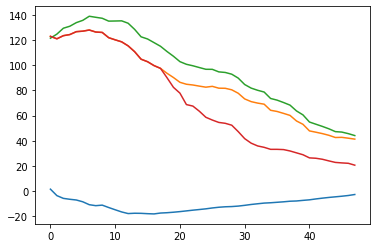

In [29]:
tmp = pred(pp, means*0, norm=1)
plt.plot(tmp[padl:-padr])
tmp = pred(pp, means, norm=1)
plt.plot(tmp[padl:-padr])
plt.plot(means[padl:-padr])
plt.plot(casales)
# plt.plot(tmp[padl:-padr])
# plt.plot(tmp[padl:-padr]+means[padl:-padr])
# plt.plot(tmp[padl:-padr]*0.01+means[padl:-padr])

In [30]:
   
# def pred(p, means, prior=False, norm=None):
#     u, v = p[:p.size//2], p[p.size//2:]
#     s = u + 1j*v
#     x = np.fft.irfft(s, norm='ortho')

#     if norm is not None: x*= norm
#     x += means
#     if prior: 
#         ps = abs(s)**2
#         return x, ps
#     else: return x

In [31]:
alpreds=np.array(alpreds)
ia1 = np.where(als == 1)[0][0]
ib1 = np.where(bts == 1)[0][0]
bts[ib1], als[ia1]

(1.0, 1.0)

-0.44738257402765447
(array([137]), array([0]))


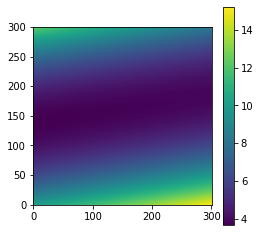

In [32]:
nn = 1
plt.figure(figsize=(nn*4, 4))
plt.subplot(1,nn,1)

covpred = cov[padl+i1:-padr, padl+i1:-padr]
icovpred = np.linalg.inv(covpred)

chimatrix = np.zeros((als.size, bts.size))
mina, minb = None, None
chimin = 100
for ia, aa in enumerate(als):
    for ib, bb in enumerate(bts):

        m = alpreds[ia][ib][padl+i1:-padr]
        diff = m - casales[i1:]
        chi = np.dot(np.dot(diff, icovpred), diff)
        if chi < chimin: 
            chimin = chi
            mina, minb = ia, ib
        chimatrix[ia, ib] = chi

plt.imshow(chimatrix, origin='lower')
# plt.imshow(chimatrix)
plt.colorbar()
print(chimatrix.min()-chimatrix[ib1, ib1])
minindex= np.where(chimatrix ==chimatrix.min())
print(minindex)

In [33]:
als[mina], als[minb]

(0.937, 0.8)

In [34]:
print(chimatrix[ia1, ib1])
print(chimatrix[mina, minb])
print(chimatrix[mina, 0])
print(chimatrix[ia1, ib1] - chimatrix[mina, minb])

4.143313198580826
3.695930624553171
3.695930624553171
0.44738257402765447


(3.1433131985808256, 5.143313198580826)

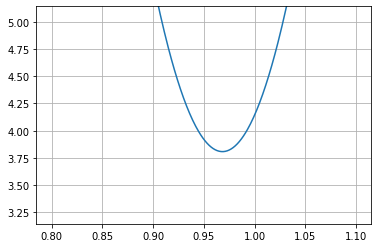

In [35]:
plt.plot(als, chimatrix[:, ib1])
plt.grid()
plt.ylim(-1+chimatrix[ia1, ib1] , 1+chimatrix[ia1, ib1])

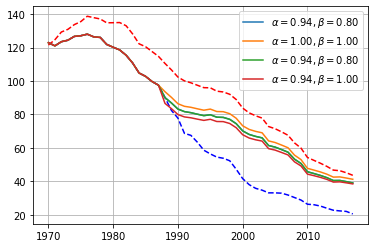

In [36]:
nn = 1
plt.figure(figsize=(nn*6, 4))
plt.subplot(1,nn,1)

# ia = minindex[0][0]
# for ib, bb in enumerate(bts[::10]):
#     m = alpreds[ia][ib][padl:-padr]
#     diff = m - casales[:]
#     plt.plot(m)
plt.plot(years, meansales, 'r--')
plt.plot(years, casales[:],'b--')
plt.plot(years, alpreds[mina][minb][padl:-padr], label=r'$\alpha=%0.2f, \beta=%0.2f$'%(als[mina], bts[minb]))
plt.plot(years, alpreds[ia1][ib1][padl:-padr], label=r'$\alpha=%0.2f, \beta=%0.2f$'%(als[ia1], bts[ib1]))
plt.plot(years, alpreds[mina][0][padl:-padr], label=r'$\alpha=%0.2f, \beta=%0.2f$'%(als[mina], bts[0]))
plt.plot(years, alpreds[mina][ib1][padl:-padr], label=r'$\alpha=%0.2f, \beta=%0.2f$'%(als[mina], bts[ib1]))
plt.legend()
plt.grid(which = 'both')

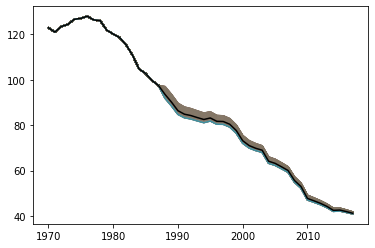

In [37]:
for ib in range(bts.size):
    plt.plot(years,alpreds[ia1][ib][padl:-padr], alpha=0.5)
plt.plot(years,alpreds[ia1][ib1][padl:-padr], 'k')

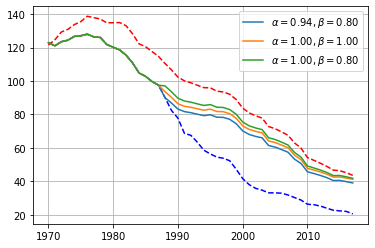

In [38]:
nn = 1
plt.figure(figsize=(nn*6, 4))
plt.subplot(1,nn,1)

# ia = minindex[0][0]
# for ib, bb in enumerate(bts[::10]):
#     m = alpreds[ia][ib][padl:-padr]
#     diff = m - casales[:]
#     plt.plot(m)
plt.plot(years, meansales, 'r--')
plt.plot(years, casales[:],'b--')

plt.plot(years, alpreds[mina][minb][padl:-padr], label=r'$\alpha=%0.2f, \beta=%0.2f$'%(als[mina], bts[minb]))
plt.plot(years, alpreds[ia1][ib1][padl:-padr], label=r'$\alpha=%0.2f, \beta=%0.2f$'%(als[ia1], bts[ib1]))
plt.plot(years, alpreds[ia1][minb][padl:-padr], label=r'$\alpha=%0.2f, \beta=%0.2f$'%(als[ia1], bts[minb]))
# plt.plot(years, alpreds[ia1][ib1][padl:-padr], label=r'$\alpha=%0.2f, \beta=%0.2f$'%(als[mina], bts[ib1]))
plt.legend()
plt.grid(which = 'both')

In [39]:
sum(np.exp(-0.5*chimatrix)*np.diff(als)[0]*np.diff(bts)[0]),  np.exp(-0.5*chimatrix[ia1, ib1])

(0.006174904048830656, 0.12597691548019227)

### Alternate 2D analysis

In [40]:
# als = np.round(np.arange(0.8, 1.2, 0.001), 3)
# bts = np.round(np.arange(0.95, 1.05, 0.001), 3)
m0s = np.round(np.arange(-20, 20, 0.5), 3)
als = np.round(np.arange(-5, 5, 0.05), 3)
bts = np.round(np.arange(-0.05, 0.05, 0.001), 3)
ia1, ib1 = np.where(als ==0)[0][0], np.where(bts==0)[0][0]
# for padl, padr in [[yy//2, yy//2], [yy, yy], [2*yy, 2*yy]]:
alpreds = []
chimatrix = np.zeros((als.size, bts.size))
mina, minb = None, None
chimin = 100
for padl, padr in [[yy//2, yy//2]]:
    ii +=1
    alpreds = []
    al = 1.
    xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr, al=al)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr, al=al)
    pktrue = pkm/tfpad
    p0 = np.ones(pkm.size*2)

    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    tomin = lambda p: chisq(p, means*al, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)

    covpred = cov[padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)

    
    xx = years - years[i1]
    xx[xx<0] = 0
    for ia, al in enumerate(als):
        p1 = xx*al
        tpred = []
        for ib, bt in enumerate(bts):
            p2 = xx**2 * bt
            m = capred[padl:-padr]+p1+p2
            tpred.append(m)
            diff = m[i1:] - casales[i1:]
            chi = np.dot(np.dot(diff, icovpred), diff)
            if chi < chimin: 
                chimin = chi
                mina, minb = ia, ib
            chimatrix[ia, ib] = chi
        alpreds.append(tpred)

print(mina, minb)

60 99


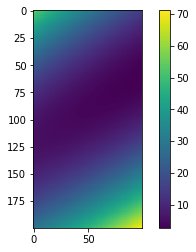

In [41]:
plt.imshow(chimatrix)
plt.colorbar()

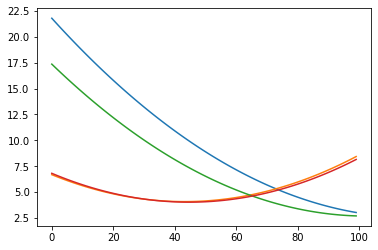

In [42]:
plt.plot(chimatrix[:][ib1])
plt.plot(chimatrix[ia1][:])
plt.plot(chimatrix[mina][:])
plt.plot(chimatrix[:][minb])


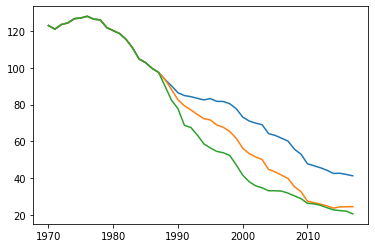

In [43]:
plt.plot(years, capred[padl:-padr])
# plt.plot(years, alpreds[0][0])
plt.plot(years, alpreds[mina][minb])
# plt.plot(years, capred[padl:-padr] + xx**2*-0.05)
plt.plot(years, casales)

In [44]:
chimatrix.shape

(200, 100)

In [45]:
np.trapz(np.trapz(chimatrix, als, axis=0), bts, axis=0)

16.62276662775931

### Alternate 2D analysis 2

In [46]:
als = np.round(np.arange(0.1, 1.5, 0.1), 3)
bts = np.round(np.arange(0.1, 1.5, 0.1), 3)
# als = np.round(np.arange(-5, 5, 0.05), 3)
# bts = np.round(np.arange(-0.05, 0.05, 0.001), 3)
ia1, ib1 = np.where(als ==1)[0][0], np.where(bts==1)[0][0]
# for padl, padr in [[yy//2, yy//2], [yy, yy], [2*yy, 2*yy]]:
alpreds = []
chimatrix = np.zeros((als.size, bts.size))
mina, minb = None, None
chimin = 100
for padl, padr in [[yy//2, yy//2]]:
    ii +=1
    alpreds = []
    al = 1.
    xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr, al=al)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr, al=al)
    pktrue = pkm/tfpad
    p0 = np.ones(pkm.size*2)

    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    tomin = lambda p: chisq(p, means*al, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capredfid = pred(pp, means)[padl:-padr]

    covpred = cov[padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)

    xx = years - years[i1-2]
    ones = np.ones_like(xx)
    ones[xx<0] = 0
    xx[xx<0] = 0
    
    for ia, al in enumerate(als):
        newmeans = means.copy()
        newmeans[padl+i1-2:] *= al
        tpred = []
        for ib, bt in enumerate(bts):
            norms = np.ones_like(newmeans)
            norms[padl+i1-2:] *= bt
            capred = pred(pp, newmeans, norm=norms)[padl:-padr]
#             p0 = capredfid[i1-1] - capred[i1-1] 
#             p1 = -1*(capredfid[i1-2] - capred[i1-2] - p0)
            p0 = capredfid[i1-2] - capred[i1-2] 
            p1 = (capredfid[i1-1] - capred[i1-1] - p0)
            capred[i1-2:] += p0 + p1*xx[i1-2:]
            tpred.append(capred)
            diff = m[i1:] - casales[i1:]
            chi = np.dot(np.dot(diff, icovpred), diff)
            if chi < chimin: 
                chimin = chi
                mina, minb = ia, ib
            chimatrix[ia, ib] = chi
        alpreds.append(tpred)

print(mina, minb)

0 0


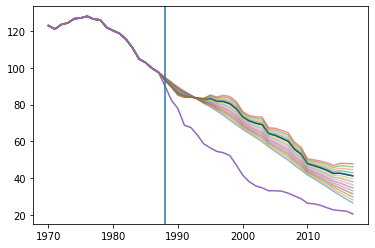

In [443]:
plt.plot(years, capredfid, 'k')
# plt.plot(years, alpreds[ia1][ib1], '--')
# plt.plot(years, alpreds[mina][minb], '--')
# for ib in range(bts.size):
#     plt.plot(years, alpreds[ia1][ib], '-', alpha=0.5)
for ia in range(als.size):
    plt.plot(years, alpreds[ia][ib1], '-', alpha=0.5)
plt.plot(years, casales)
plt.axvline(years[i1])

### Yet another 2D

In [57]:
m0s = np.round(np.arange(-20, 20, 0.5), 3)
als = np.round(np.arange(-5, 5, 0.05), 3)
bts = np.round(np.arange(-0.05, 0.05, 0.001), 3)
im1, ia1, ib1 = np.where(m0s ==0)[0][0], np.where(als ==0)[0][0], np.where(bts==0)[0][0]

alpreds = []
chimatrix = np.zeros((m0s.size, als.size, bts.size))
minm, mina, minb = None, None, None

chimin = 100
for padl, padr in [[yy//2, yy//2]]:
    ii +=1
    alpreds = []
    al = 1.
    xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr, al=al)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr, al=al)
    pktrue = pkm/tfpad
    p0 = np.ones(pkm.size*2)

    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    tomin = lambda p: chisq(p, means*al, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)

    covpred = cov[padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)

    
    xx = years - years[i1]
    xx[xx<0] = 0
    for im, m0 in enumerate(m0s):
        mpreds = []
        for ia, al in enumerate(als):
            p1 = xx*al
            tpred = []
            for ib, bt in enumerate(bts):
                p2 = xx**2 * bt
                m = capred[padl:-padr]+p1+p2+m0*xx.astype(bool)
                tpred.append(m)
                diff = m[i1:] - casales[i1:]
                chi = np.dot(np.dot(diff, icovpred), diff)
                if chi < chimin: 
                    chimin = chi
                    minm, mina, minb = im, ia, ib
                chimatrix[im, ia, ib] = chi
            mpreds.append(tpred)
        alpreds.append(mpreds)

print(minm, mina, minb)

37 61 99


In [58]:
print(m0s[minm], als[mina], bts[minb])

-1.5 -1.95 0.049


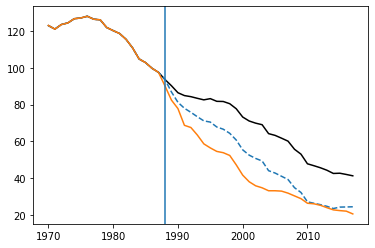

In [59]:
plt.plot(years, capredfid, 'k')
# plt.plot(years, alpreds[ia1][ib1], '--')
plt.plot(years, alpreds[minm][mina][minb], '--')
# for ib in range(bts.size):
#     plt.plot(years, alpreds[ia1][ib], '-', alpha=0.5)
# for ia in range(als.size):
#     plt.plot(years, alpreds[ia][ib1], '-', alpha=0.5)
plt.plot(years, casales)
plt.axvline(years[i1])

# Significance for other states

In [26]:
statesid

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [148]:

# i1 = 18
# yy = years.size
# allpreds = []
# als = np.round(np.arange(0.3, 1.15, 0.1), 2)
# # als = np.round(np.arange(0.3, 1.15, 0.5), 2)
# padl, padr = yy, yy
# yearspad = np.pad(years, (padl, padr), mode='linear_ramp', end_values=(years[0]-padl, years[-1]+padr))
# chis = []

# for ss in statesid:
#     statesales = {}
#     print(ss)
#     for s in statesid:
#         loc = sales['LocationAbbr'] == s
#         years = sales[loc]['Year'].values.astype('float32')
#         statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

#     tmp = statesales['CA'].copy() 
#     statesales['CA'] = statesales[ss].copy()
#     statesales[ss] = tmp.copy()

#     salearray = np.zeros((len(ils), years.size))
#     for i in range(len(statesid)): salearray[i] = statesales[ils[i]]

#     salearrayca = []
#     for i in range(len(statesid)):
#         if ils[i] == 'CA': continue
#         else: salearrayca.append(statesales[ils[i]])
#     salearrayca = np.array(salearrayca)

#     casales = statesales['CA']
#     meansales = salearray.mean(axis=0)
    
    
#     xp, means, pk, pkca = setupdata(padl, padr)
#     pkm = pk.mean(axis=0)
#     ffpad  = getf(padl, padr)
#     tfpad = gettfprior(padl, padr)
#     pktrue = pkm/tfpad
#     p0 = np.ones(pkm.size*2)
   
    
#     cov = getcov(pktrue, padl, padr)
#     err = cov.diagonal()**0.5
#     covpred = cov[padl+i1:-padr, padl+i1:-padr]
#     icovpred = np.linalg.inv(covpred)
#     alpreds = []
#     alchis = []
#     capreds = []
#     for al in als:
#         tomin = lambda p: chisq(p, means*al, casales, pktrue, padl)
#         pp = minimize(tomin, p0).x
#         capred = pred(pp, means*al)
#         capreds.append(capred)
#         alpreds.append([capred, err, cov, casales, meansales])
#         m = capred[padl+i1:-padr]
#         diff = m - casales[i1:]
#         alchis.append(np.dot(np.dot(diff, icovpred), diff))
#     capreds = np.array(capreds)
#     tosave = np.vstack([years, casales, meansales]).T
#     np.savetxt('./alpreds/%s-data.txt'%ss, tosave, header='years, casales, meansales', fmt='%.2f')
#     tosave = np.vstack([yearspad, capreds]).T
#     np.savetxt('./alpreds/%s-pred.txt'%ss, tosave, header='yearspad, alpred\n'+str(als), fmt='%.2f')
#     np.save('./alpreds/%s-cov'%ss, cov)
#     allpreds.append(alpreds)
#     chis.append(np.array(alchis))

In [24]:

i1 = 18
yy = years.size
allpreds2 = []
als = np.round(np.arange(0.6, 1.05, 0.02), 2)
# als = np.round(np.arange(0.3, 1.15, 0.5), 2)
padl, padr = yy, yy
yearspad = np.pad(years, (padl, padr), mode='linear_ramp', end_values=(years[0]-padl, years[-1]+padr))
chis2 = []

for ss in statesid:
    tstatesales = {}
    print(ss)
    for s in statesid:
        loc = sales['LocationAbbr'] == s
        years = sales[loc]['Year'].values.astype('float32')
        tstatesales[s] = sales[loc]['Data_Value'].values.astype('float32')

    tmp = tstatesales['CA'].copy() 
    tstatesales['CA'] = tstatesales[ss].copy()
    tstatesales[ss] = tmp.copy()

    tsalearray = np.zeros((len(ils), years.size))
    for i in range(len(statesid)): tsalearray[i] = tstatesales[ils[i]]

    tsalearrayca = []
    for i in range(len(statesid)):
        if ils[i] == 'CA': continue
        else: tsalearrayca.append(tstatesales[ils[i]])
    tsalearrayca = np.array(tsalearrayca)

    tcasales = tstatesales['CA']
    meansales = tsalearray.mean(axis=0)
    
    xp, means, pk, pkca = setupdata(tsalearrayca, tcasales, padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(tsalearrayca, padl, padr)
    pktrue = pkm/tfpad
    p0 = np.ones(pkm.size*2)
       
    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    covpred = cov[padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)
    alpreds = []
    alchis = []
    tomin = lambda p: chisq(p, means, tcasales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capreds = []
    for al in als:
        newmeans = means.copy()
        newmeans[padl+i1:] *= al
        capred = pred(pp, newmeans)
        alpreds.append([capred, err, cov, tcasales, meansales])
        m = capred[padl+i1:-padr]
        diff = m - tcasales[i1:]
        alchis.append(np.dot(np.dot(diff, icovpred), diff))
        capreds.append(capred)
    capreds = np.array(capreds)
    tosave = np.vstack([years, tcasales, meansales]).T
    np.savetxt('./alpreds2/%s-data.txt'%ss, tosave, header='years, casales, meansales', fmt='%.2f')
    tosave = np.vstack([yearspad, capreds]).T
    np.savetxt('./alpreds2/%s-pred.txt'%ss, tosave, header='yearspad, alpred\n'+str(als), fmt='%.2f')
    np.save('./alpreds2/%s-cov'%ss, cov)
    allpreds2.append(alpreds)
    chis2.append(np.array(alchis))

AL
AK
AZ
AR
CA
CO
CT
DE
DC
FL
GA
HI
ID
IL
IN
IA
KS
KY
LA
ME
MD
MA
MI
MN
MS
MO
MT
NE
NV
NH
NJ
NM
NY
NC
ND
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VT
VA
WA
WV
WI
WY


Text(0, 0.5, '$\\Delta \\chi^2$')

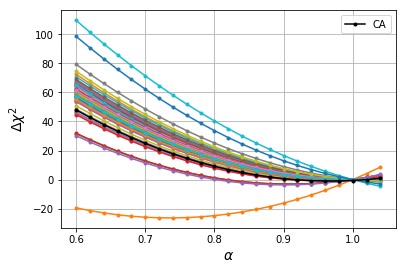

In [69]:
for i in range(len(chis)):
#     plt.plot(als,chis2[i]-chis2[i][als==1], '-', marker='.', label= statesid[i])
    plt.plot(als,chis2[i]-chis2[i][als==1], '-', marker='.')
i = 4
plt.plot(als,chis2[i]-chis2[i][-2], 'k-', marker='.', label= statesid[i])

plt.legend()
plt.grid()
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$\Delta \chi^2$', fontsize=14)



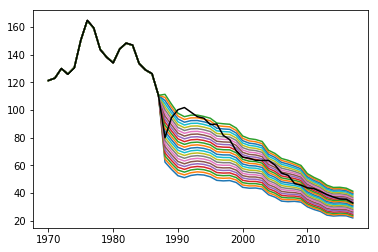

In [61]:
ii = 1
for i in range(als.size):
    plt.plot(years, allpreds2[ii][i][0][padl:-padr])
plt.plot(years, allpreds2[ii][0][3], 'k')
    

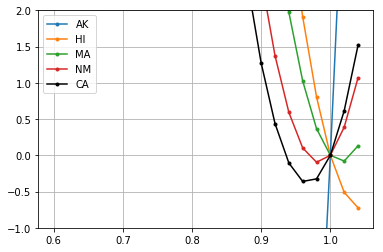

In [74]:
for i in range(len(chis)):
    if ils[i] in ['AK', 'HI', 'MA', 'NM']:
        plt.plot(als,chis2[i]-chis2[i][als==1], '-', marker='.', label= statesid[i])
#     plt.plot(als,chis2[i]-chis2[i][-2], '-', marker='.', label)
i = 4
plt.plot(als,chis2[i]-chis2[i][als==1], 'k-', marker='.', label= statesid[i])
# plt.axvline(0.97)
plt.ylim(-1, 2)
plt.legend()
plt.grid()

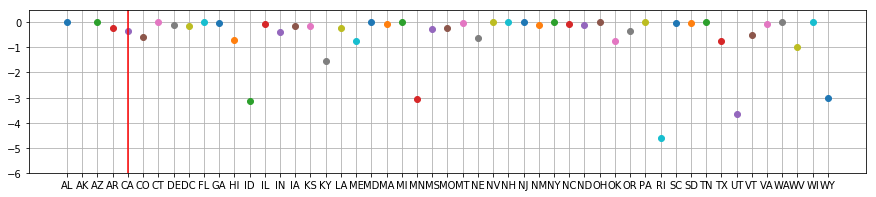

In [84]:
plt.figure(figsize = (15, 3))
for i in range(len(chis)):
        plt.plot(i, chis2[i].min()-chis2[i][als==1], '-', marker='o')
plt.grid(which='both')
xticks([ii for ii in ils], [ils[ii] for ii in ils])
plt.axvline(4, color='r')
plt.ylim(-6, 0.5)
plt.show()



array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False])

(-1, 2)

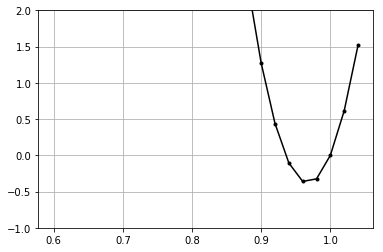

In [52]:
i = 4
plt.plot(als,chis2[i]-chis2[i][als == 1], 'k-', marker='.', label= statesid[i])
plt.grid(which='both')
plt.ylim(-1, 2)

In [30]:
len(allpreds2[4])

9

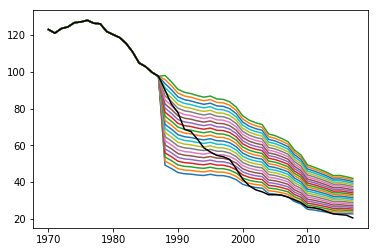

In [45]:
for i in range(als.size):
    plt.plot(years, allpreds2[4][i][0][padl:-padr])
plt.plot(years, allpreds2[4][0][3], 'k')
    

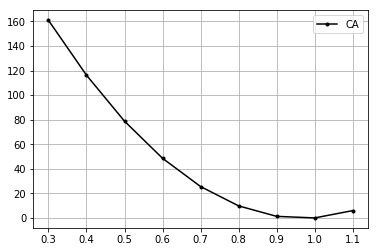

In [28]:
# for i in range(len(chis2)):
# #     plt.plot(als,chis[i]-chis[i][-2], '-', marker='.', label= statesid[i])
#     plt.plot(als,chis2[i]-chis2[i][-2], '-', marker='.')
i = 4
plt.plot(als,chis2[i]-chis2[i][-2], 'k-', marker='.', label= statesid[i])

plt.legend()
plt.grid()

TN


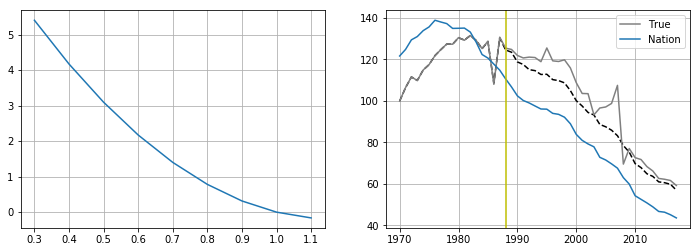

In [213]:
plt.figure(figsize=(12, 4))
ii = 42
print(ils[ii])
plt.subplot(121)
plt.plot(als, chis[ii]-chis[ii][-2])
plt.grid()

plt.subplot(122)
plt.plot(years, preds[ii][-2][0][padl:-padr], 'k--')
plt.plot(years, preds[ii][0][3], 'gray', label='True')
plt.plot(years, preds[ii][0][4], label='Nation')
plt.grid()
plt.legend()

# plt.plot(years, preds[ii][4][0][padl:-padr], 'r:')

plt.axvline(years[i1], color='y')

In [180]:
tmp = []
for ii in range(50):
    diff = preds[ii][-2][0][padl:-padr][years==2000]-preds[ii][0][3][years==2000]
    tmp.append([min(chis[ii]-chis[ii][-2]), diff])
tmp = np.array(tmp)

In [206]:
ils[29]

'NH'

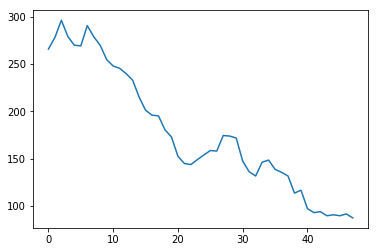

In [204]:
plt.plot(statesales['NH'])

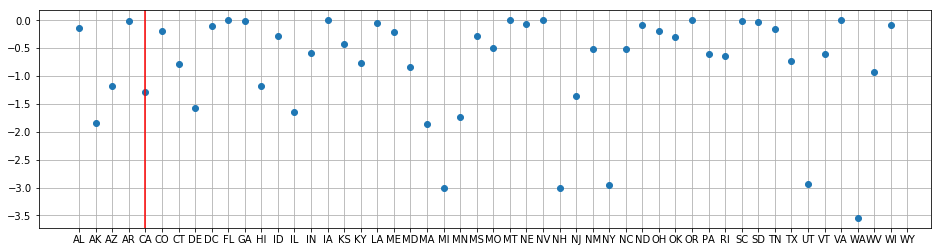

In [191]:
plt.figure(figsize = (16, 4))
plt.plot(tmp[:, 0], 'o')
plt.grid(which='both')
xticks([ii for ii in ils], [ils[ii] for ii in ils])
plt.axvline(4, color='r')
plt.show()


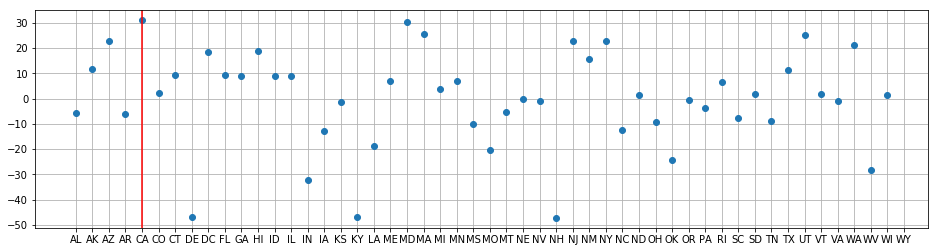

In [192]:
plt.figure(figsize = (16, 4))
plt.plot(tmp[:, 1], 'o')
plt.grid(which='both')
xticks([ii for ii in ils], [ils[ii] for ii in ils])
plt.axvline(4, color='r')
plt.show()


## p value sig of other states

In [31]:
i1 = 18
yy = years.size
statepreds = []
als = np.round(np.arange(0.3, 1.15, 0.1), 2)
padl, padr = yy, yy

for ss in statesid:
    statesales = {}
    print(ss)
    for s in statesid:
        loc = sales['LocationAbbr'] == s
        years = sales[loc]['Year'].values.astype('float32')
        statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

    tmp = statesales['CA'].copy() 
    statesales['CA'] = statesales[ss].copy()
    statesales[ss] = tmp.copy()

    salearray = np.zeros((len(ils), years.size))
    for i in range(len(statesid)): salearray[i] = statesales[ils[i]]

    salearrayca = []
    for i in range(len(statesid)):
        if ils[i] == 'CA': continue
        else: salearrayca.append(statesales[ils[i]])
    salearrayca = np.array(salearrayca)

    casales = statesales['CA']
    meansales = salearray.mean(axis=0)
    
    
    xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr)
    pktrue = pkm/tfpad
    p0 = np.ones(pkm.size*2)
   
    
    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    covpred = cov[padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)
    tomin = lambda p: chisq(p, means, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)
    statepreds.append([capred, err, cov, casales, meansales])
    

AL
AK
AZ
AR
CA
CO
CT
DE
DC
FL
GA
HI
ID
IL
IN
IA
KS
KY
LA
ME
MD
MA
MI
MN
MS
MO
MT
NE
NV
NH
NJ
NM
NY
NC
ND
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VT
VA
WA
WV
WI
WY


In [36]:
import scipy.stats as stats

No handles with labels found to put in legend.
No handles with labels found to put in legend.


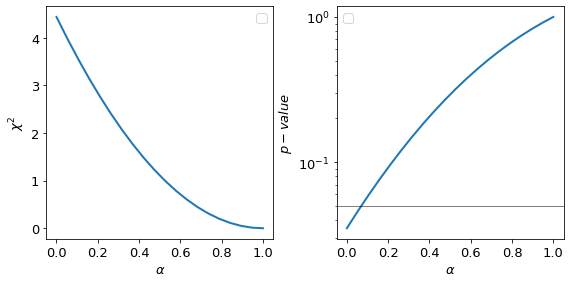

In [37]:
fig = plt.figure(figsize = (8, 4))
fsize = 13
padl, padr = yy, yy
loc = np.where(years == 2000)[0][0]
tmp = []
for ii in [4]:
    capred, err, cov, casales, meansales = statepreds[ii]
    catrue = casales[i1:]
    covpred = cov[padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)
    mod = lambda al: capred[padl+i1:-padr] + al*(catrue - capred[padl+i1:-padr])
    sig = lambda al: np.dot(np.dot(mod(al)-catrue, icovpred), mod(al)-catrue)
    alpha = np.linspace(0, 1, 20)
    tmp = [sig(al) for al in alpha]

    ax = plt.subplot(121)
    plt.plot(alpha, tmp, lw=2)
    plt.ylabel(r'$\chi^2$', fontsize=fsize)
    plt.xlabel(r'$\alpha$', fontsize=fsize)
    ax = plt.subplot(122)
    plt.plot(alpha, stats.chi2.sf(np.array(tmp), 1), lw=2)
    plt.ylabel(r'$p-value$', fontsize=fsize)
    plt.xlabel(r'$\alpha$', fontsize=fsize)
    plt.yscale('log')
    plt.axhline(0.05, color='k', lw=0.5)
plt.tight_layout()
axar = fig.get_axes()
for ax in axar: 
    ax.legend(fontsize=fsize)
    for axis in [ax.xaxis, ax.yaxis]:
        for tick in axis.get_major_ticks(): tick.label.set_fontsize(fsize)


In [38]:
stats.chi2.sf(sig(0), 1)

0.035118153359805684

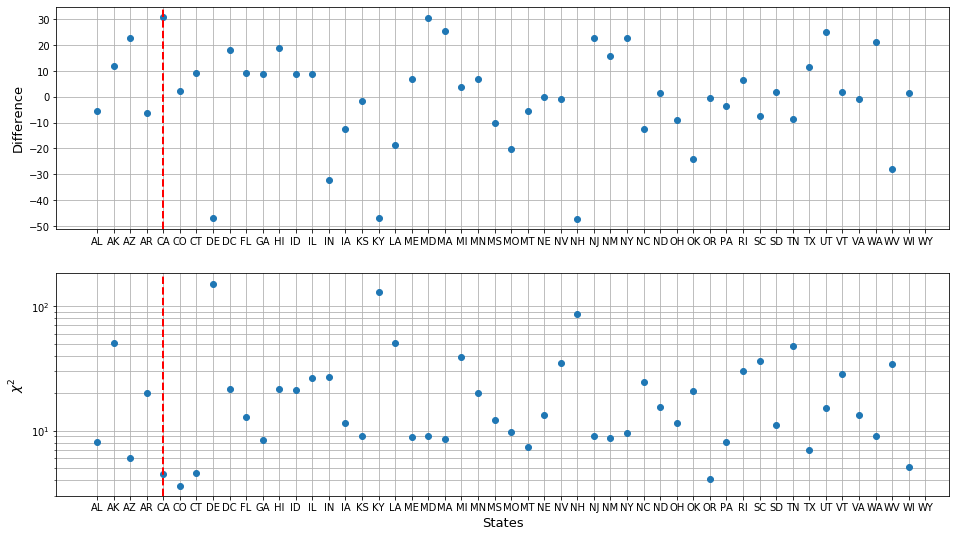

In [39]:
padl, padr = yy, yy
loc = np.where(years == 2000)[0][0]
tmp = []
for ii in range(50):
    capred, err, cov, casales, meansales = statepreds[ii]
    catrue = casales[i1:]
    covpred = cov[padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)
    mod = lambda al: capred[padl+i1:-padr] + al*(catrue - capred[padl+i1:-padr])
    sig = lambda al: np.dot(np.dot(mod(al)-catrue, icovpred), mod(al)-catrue)
    alpha = np.linspace(0, 1, 20)
#     tmp.append([sig(al) for al in alpha])
    diff = capred[loc+padl] - casales[loc]
    tmp.append([sig(0) , diff])
tmp = np.array(tmp)

plt.figure(figsize = (16, 9))

ax = plt.subplot(211)
plt.plot(tmp[:, 1], 'o')
plt.grid(which='both')
xticks([ii for ii in ils], [ils[ii] for ii in ils])
plt.ylabel('Difference', fontsize=fsize)
plt.axvline(4, color='r', lw=2, ls="--")


ax = plt.subplot(212)
plt.plot(tmp[:, 0], 'o')
plt.grid(which='both')
plt.yscale('log')
xticks([ii for ii in ils], [ils[ii] for ii in ils])
plt.ylabel(r'$\chi^2$', fontsize=fsize)
plt.axvline(4, color='r', lw=2, ls="--")

plt.xlabel('States', fontsize=fsize)
plt.show()



In [195]:
ii = [i for i in range(len(ils)) if ils[i]=='VT'][0]
ii

45

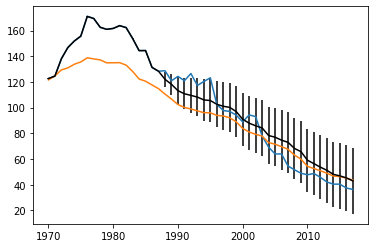

[ -6.67441788  -2.79765955 -11.14938278 -10.12767291 -17.00362855
  -9.02235463 -14.32778016 -17.69945261   0.08945423   3.3193987
   3.15748375   2.78849222   2.01001171  -6.45188384  -7.16121452
   6.26616965   9.0509163   13.04469001  10.72472834  18.45538108
  16.59263158  16.79419957  11.33195036   7.63607807   7.93008726
   9.07209349   7.62362099   6.45184835   7.85708963   6.67934324]
28.6605901149243


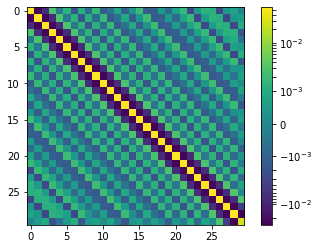

In [196]:
scapred, serr, scov, scasales, smeansales =  statepreds[ii]
scapred, serr = scapred[padl:-padr], serr[padl:-padr]
plt.plot(years, scasales)
plt.plot(years, smeansales)
plt.errorbar(years, scapred, serr, color='k')
plt.show()

diff = scapred[i1:] - scasales[i1:]
print(diff)
sicovpred = np.linalg.inv(scov[padl+i1:-padr, padl+i1:-padr])
print(np.dot(diff, np.dot(sicovpred, diff)))
# plt.imshow(sicovpred)
plt.imshow((sicovpred), norm=SymLogNorm(0.001))
plt.colorbar()

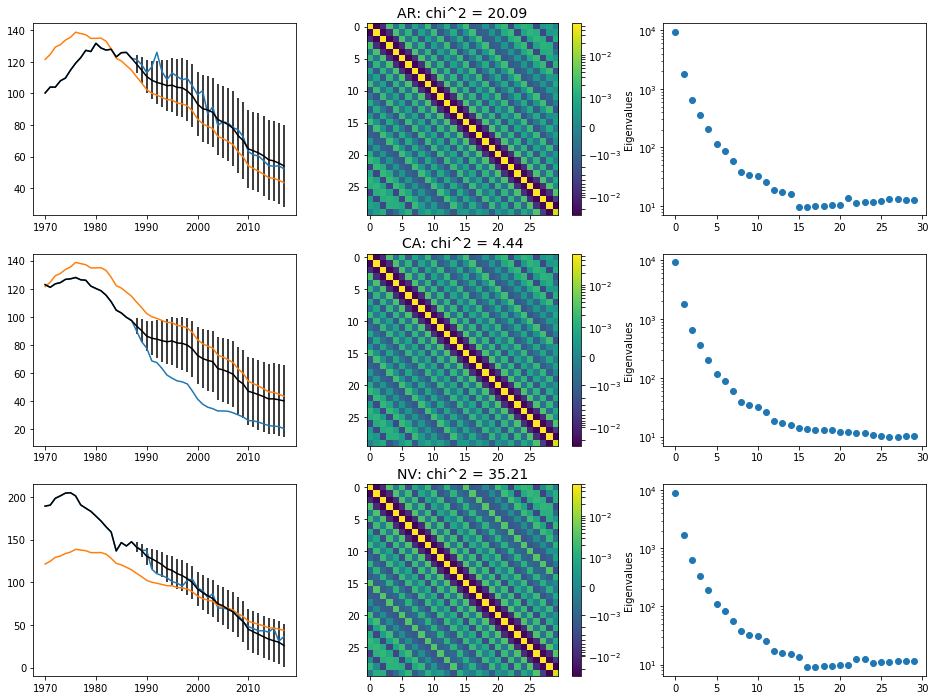

In [51]:
fig = plt.figure(figsize=(16, 12))
for i, ii in enumerate([3, 4, 28]):

    scapred, serr, scov, scasales, smeansales =  statepreds[ii]
    scovpred = scov[padl+i1:-padr, padl+i1:-padr]
    sicovpred = np.linalg.inv(scovpred)

    ax = plt.subplot(3,3,3*i+1)
    plt.plot(years, scasales)
    plt.plot(years, smeansales)
    plt.errorbar(years, scapred[padl:-padr], serr[padl:-padr], color='k')

    ax = plt.subplot(3,3,3*i+2)
    plt.imshow((sicovpred), norm=SymLogNorm(0.001))
    plt.colorbar()
    
    diff = scapred[padl+i1:-padr] - scasales[i1:]
    plt.title(ils[ii] + ': chi^2 = %.2f'%np.dot(diff, np.dot(sicovpred, diff)), fontsize=14)

    ax = plt.subplot(3,3,3*i+3)
    plt.plot(np.linalg.eigvals(scovpred), 'o')
    plt.yscale('log')
    ax.set_ylabel('Eigenvalues')
    

In [157]:
loc = np.where(years == 2000)[0][0]
tmp = []
tmpeig = []
for ii in range(50):
    capred, err, cov, casales, meansales = statepreds[ii]
    catrue = casales[i1:]
    capred = capred[padl+i1:-padr]
    covpred = cov[padl+i1:-padr, padl+i1:-padr]
    icovpred = np.linalg.inv(covpred)
    seigs, seigv = np.linalg.eig(icovpred)
    tmpeig.append((seigs, seigv, np.dot(seigv.T, catrue), np.dot(seigv.T, capred)))
    mod = lambda al: capred + al*(catrue - capred)
    sig = lambda al: np.dot(np.dot(mod(al)-catrue, icovpred), mod(al)-catrue)
    alpha = np.linspace(0, 1, 20)
#     tmp.append([sig(al) for al in alpha])
    diff = capred[loc-i1] - casales[loc]
    tmp.append([sig(0) , diff])
tmp = np.array(tmp)




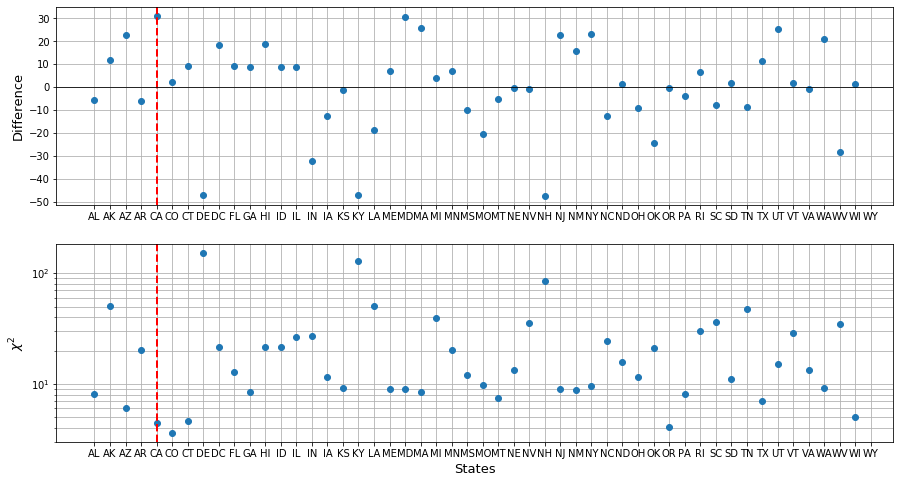

In [211]:
plt.figure(figsize=(15, 8))
ax = plt.subplot(211)
plt.plot(tmp[:, 1], 'o')
plt.grid(which='both')
xticks([ii for ii in ils], [ils[ii] for ii in ils])
plt.ylabel('Difference', fontsize=fsize)
plt.axvline(4, color='r', lw=2, ls="--")
plt.axhline(0, color='k', lw=0.8)

ax = plt.subplot(212)
plt.plot(tmp[:, 0], 'o')
plt.grid(which='both')
plt.yscale('log')
xticks([ii for ii in ils], [ils[ii] for ii in ils])
plt.ylabel(r'$\chi^2$', fontsize=fsize)
plt.axvline(4, color='r', lw=2, ls="--")

plt.xlabel('States', fontsize=fsize)
plt.show()



In [158]:
# (np.dot(np.dot(seigv, np.diag(seigs**1)), seigv.T)/ icovpred);
# (np.dot(seigv.T, capred - catrue)**2)*seigs).sum(),  sig(0)

In [212]:
iplot = [i for i in range(len(ils)) if ils[i] in ['AK', 'CA', 'DC', 'NV', 'VT']]

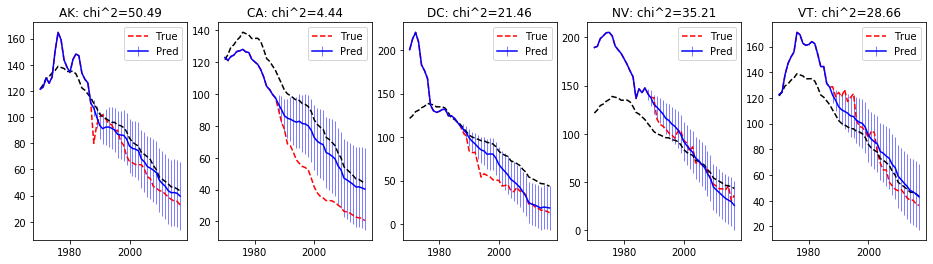

In [247]:
plt.figure(figsize = (16, 4))
for i, ii in enumerate(iplot):
    scapred, serr, scov, scasales, smeansales =  statepreds[ii]
    scapred, serr = scapred[padl:-padr], serr[padl:-padr]
    plt.subplot(1, 5, i+1)
    plt.plot(years, scasales, ls = "--", color='r', label='True')
    plt.plot(years, smeansales, 'k--')
    plt.errorbar(years, scapred, serr, color='b', elinewidth=0.5, label='Pred')
    plt.title(ils[ii] + ': chi^2=%.2f'%tmp[ii][0])
    plt.legend()

AK 50.49181276647993 50.491812766439004
CA 4.439421105596627 4.439421105647886
DC 21.455963538259436 21.455963538247403
NV 35.20918347336892 35.209183473356624
VT 28.66059011489457 28.660590114924318


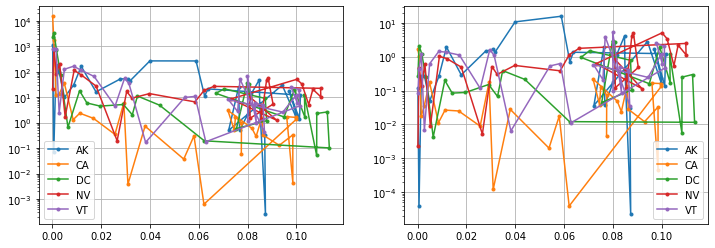

In [249]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
for ii in iplot: 
    print(ils[ii], (tmpeig[ii][0]* (tmpeig[ii][3]-tmpeig[ii][2])**2).sum(), tmp[ii][0])
    plt.plot(tmpeig[ii][0], (tmpeig[ii][3]-tmpeig[ii][2])**2,  label=ils[ii], marker='.')
# plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()

plt.subplot(122)
for ii in iplot: 
    plt.plot(tmpeig[ii][0], tmpeig[ii][0]*(tmpeig[ii][3]-tmpeig[ii][2])**2,  label=ils[ii], marker='.')
# plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()

# Make figure

In [98]:
statesales = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    statesales[s] = sales[loc]['Data_Value'].values.astype('float32')

ss = 'CA'
tmp = statesales['CA'].copy() 
statesales['CA'] = statesales[ss].copy()
statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)): salearray[i] = statesales[ils[i]]
    
salearrayca = []
for i in range(len(statesid)):
    if ils[i] == 'CA': continue
    else: salearrayca.append(statesales[ils[i]])
salearrayca = np.array(salearrayca)

i1 = 18
yy = years.size

casales = statesales['CA']
meansales = salearray.mean(axis=0)



Expected difference :  [31.0518546]


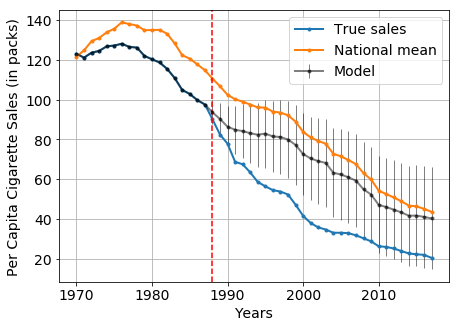

In [197]:
######################################################
plt.figure(figsize=(7, 5))
fsize = 14
ii = 0 
preds = []
# for padl, padr in [[1, 1],  [10, 10], [yy//2, yy//2], [yy, yy]]:
for padl, padr in [[yy, yy]]:
    ii +=1
    xp, means, pk, pkca = setupdata(padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(padl, padr)
    pktrue = pkm/tfpad
    
    p0 = np.ones(pkm.size*2)
    tomin = lambda p: chisq(p, means, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)
        
    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    preds.append([capred, err])

#     if padr: plt.errorbar(years, capred[padl:-padr], err[padl:-padr], color='k', alpha=0.5, lw=2, elinewidth=1, label='Predict\n(padratio=%.2f)'%(2*padl/yy))
    if padr: plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1, label='Model', color='k', marker='.')
    else: plt.errorbar(years, capred[padl:], err[padl:], alpha=1, lw=2, elinewidth=1, label=ii)
    print('Expected difference : ', capred[padl:-padr][years==2000] - casales[years==2000])
#     plt.title(' Expected difference : %.2f'%(capred[padl:-padr][years==2000] - casales[years==2000]))
    
plt.plot(years, casales, marker='.', lw=2, label='True sales')
plt.plot(years, meansales, marker='.', lw=2, label='National mean')
plt.xlabel('Years', fontsize=fsize)
plt.ylabel('Per Capita Cigarette Sales (in packs)', fontsize=fsize)
plt.grid()
plt.legend(fontsize=fsize)
plt.axvline(years[i1], ls="--", color='r')
ax = plt.gca()
# for axis in ax.flatten():
#     for tick in axis.xaxis.get_major_ticks():
#         tick.label.fontsize(fsize)
#     for tick in axis.yaxis.get_major_ticks():
#         tick.label.set_fontproperties(fontmanage)
for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks(): tick.label.set_fontsize(fsize)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


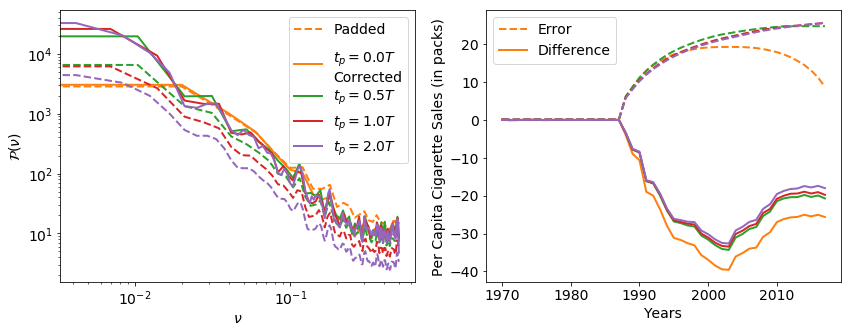

In [103]:
######################################################
fig = plt.figure(figsize=(14, 5))
fsize = 14
ii = 0 
preds = []
for padl, padr in [[1, 1], [yy//2, yy//2], [yy, yy], [2*yy, 2*yy]]:
# for padl, padr in [[1, 1], [yy//2, yy//2]]:
    ii +=1
    xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr)
    pktrue = pkm/tfpad

    lbls = ['', '']
    if ii == 1: lbls = ['Padded', '\nCorrected']
    ax = plt.subplot(121)
    ax.plot(ffpad, pkm, 'C%d--'%ii, lw=2, label=lbls[0])
    ax.plot(ffpad, pktrue, 'C%d-'%ii, label='$t_p = %.1fT$'%(padl/yy) + lbls[1], lw=2)
    plt.xlabel(r'$\nu$', fontsize=fsize)
    plt.ylabel(r'$\mathcal{P}(\nu)$', fontsize=fsize)
    plt.xscale('log')
    plt.yscale('log')
    
    p0 = np.ones(pkm.size*2)

    ax = plt.subplot(122)
    tomin = lambda p: chisq(p, means, casales, pktrue, padl)
    pp = minimize(tomin, p0).x
    capred = pred(pp, means)
        
    cov = getcov(pktrue, padl, padr)
    err = cov.diagonal()**0.5
    lbls = [None, None]
    if ii == 1: lbls= ['Error', 'Difference']
    ax.plot(years, err[padl:-padr], 'C%d--'%ii, lw=2, label=lbls[0])
    ax.plot(years, casales - capred[padl:-padr], 'C%d'%ii, lw=2, label=lbls[1])
    preds.append([capred, err])
    plt.xlabel('Years', fontsize=fsize)
    plt.ylabel('Per Capita Cigarette Sales (in packs)', fontsize=fsize)

# plt.grid()
axar = fig.get_axes()
for ax in axar: 
    ax.legend(fontsize=fsize)
    for axis in [ax.xaxis, ax.yaxis]:
        for tick in axis.get_major_ticks(): tick.label.set_fontsize(fsize)



# 2 data

In [27]:
d1 = costarray - costarray.mean(axis=0)
d2 = salearray - salearray.mean(axis=0)

In [41]:
padl, padr = 0, 0
yearspad = np.pad(years, (padl, padr), mode='linear_ramp', end_values=(years[0]-padl, years[-1]+padr))
ffpad = getf(padl, padr)

d = np.pad(salearray.copy(), [(0, 0), (padl, padr)], mode='constant', constant_values=0)
means = d.mean(axis=0)
std = d.std(axis=0)
xp1 = d - means
# xp1[:, padl:-padr] /= std[padl:-padr]

d = np.pad(costarray.copy(), [(0, 0), (padl, padr)], mode='constant', constant_values=0)
means = d.mean(axis=0)
std = d.std(axis=0)
xp2 = d - means
# xp2[:, padl:-padr] /= std[padl:-padr]

d = np.pad(pincarray.copy(), [(0, 0), (padl, padr)], mode='constant', constant_values=0)
means = d.mean(axis=0)
std = d.std(axis=0)
xp3 = d - means
# xp3[:, padl:-padr] /= std[padl:-padr]

pss1 = []
for i in range(xp.shape[0]): pss1.append(psfunc(xp1[i]))
pss1 = np.array(pss1)

pss12 = []
for i in range(xp.shape[0]): pss12.append(psfunc(xp1[i], xp2[i]))
pss12 = np.array(pss12)
pss2 = []
for i in range(xp.shape[0]): pss2.append(psfunc(xp2[i]))
pss2 = np.array(pss2)

pss13 = []
for i in range(xp.shape[0]): pss13.append(psfunc(xp1[i], xp3[i]))
pss13 = np.array(pss13)
pss3 = []
for i in range(xp.shape[0]): pss3.append(psfunc(xp3[i]))
pss3 = np.array(pss3)

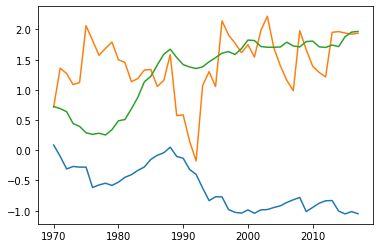

In [42]:
ii = 21
plt.plot(yearspad, xp1[ii]/xp1.std(axis=0))
plt.plot(yearspad, xp2[ii]/xp2.std(axis=0))
plt.plot(yearspad, xp3[ii]/xp3.std(axis=0))

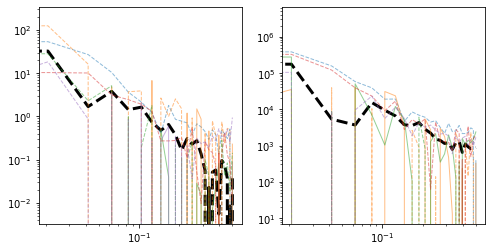

In [30]:
plt.figure(figsize = (8, 4))

plt.subplot(121)
plt.plot(ffpad, pss12.mean(axis=0), 'k-', lw=3)
plt.plot(ffpad, -pss12.mean(axis=0), 'k--', lw=3)
for i in range(5):
    plt.plot(ffpad, pss12[i], 'C%d-'%i, lw=1, alpha=0.5)
    plt.plot(ffpad, -pss12[i], 'C%d--'%i, lw=1, alpha=0.5)
plt.yscale('log')
plt.xscale('log')

plt.subplot(122)
plt.plot(ffpad, pss13.mean(axis=0), 'k-', lw=3)
plt.plot(ffpad, -pss13.mean(axis=0), 'k--', lw=3)
for i in range(5):
    plt.plot(ffpad, pss13[i], 'C%d-'%i, lw=1, alpha=0.5)
    plt.plot(ffpad, -pss13[i], 'C%d--'%i, lw=1, alpha=0.5)
plt.yscale('log')
plt.xscale('log')


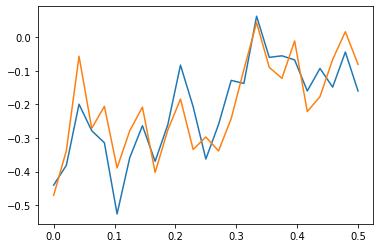

In [31]:
plt.plot(ffpad, (pss12/(pss1*pss2)**0.5).mean(axis=0))
plt.plot(ffpad, (pss12.mean(axis=0)/(pss1.mean(axis=0)*pss2.mean(axis=0))**0.5))

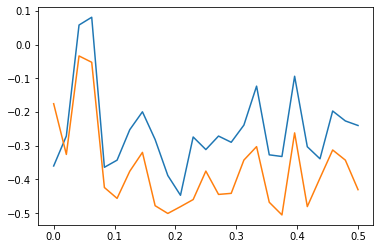

In [32]:
plt.plot(ffpad, (pss13/(pss1*pss3)**0.5).mean(axis=0))
plt.plot(ffpad, (pss13.mean(axis=0)/(pss1.mean(axis=0)*pss3.mean(axis=0))**0.5))

## Do Analysis

In [33]:
psfunc()

TypeError: psfunc() missing 1 required positional argument: 'x'

In [31]:
np.conj(1+1j)

(1-1j)

In [171]:
# # def pred2d(p, means, prior=False):
# #     u, v = p[:p.size//2], p[p.size//2:]
# #     s = u + 1j*v
# #     x = np.fft.irfft(s, norm='ortho') + means
# #     if prior: 
# #         ps = abs(s)**2
# #         return x, ps
# #     else: return x


# def chisq2d(p, nc, means, vals, priorka, priorkx, padl, padr, sigma=1, i1=18, preds=False):
#     pc = p.reshape(-1, nc)
#     nd = pc.shape[0]
#     ss = []
#     xx = []
#     psa, psx = [], []
#     for i in range(nc):
#         ss.append(pc[:, i][:nd//2] + 1j*pc[:, i][nd//2:])
#         xx.append(np.fft.irfft(ss[-1], norm='ortho') + means[i])
#         psa.append(abs(ss[-1])**2)
#     for i in range(nc):
#         for j in range(i+1, nc):
#             psx.append((ss[i]*ss[j].conj()))
            
#     sigma = [0.01, 0.01]
#     res = sum((xx[0][padl:padl+i1] - vals[0][:i1])**2 / sigma[0]**2)
#     prior = psa[0]*priorka[0]
                           
#     for i in range(1, nc):
#         if padr: res += sum((xx[i][padl:-padr] - vals[i][:])**2 / sigma[i]**2)
#         else: res += sum((xx[i][padl:] - vals[i][:])**2 / sigma[i]**2)
#         prior += psa[i]*priorka[i]
        
#     ix = 0
#     for i in range(nc):
#         for j in range(i+1, nc):
#             prior += abs(2*psx[ix].real*priorkx[ix])
#             ix +=1
#     if preds: return xx
#     else: return sum(res) + sum(prior)


# nc = 2
# # padl, padr = years.size//2, years.size//2
# # padl, padr = years.size, years.size
# padl, padr = 0, 0

# xp1, means1, pk1, pkca1 = setupdata(salearrayca, casales, padl, padr)
# pkm1 = pk1.mean(axis=0)
# # tfpad = gettfprior(salearrayca, padl, padr)
# # pkm1 = pkm1/tfpad

# xp2, means2, pk2, pkca2 = setupdata(costarrayca, cacosts, padl, padr)
# pkm2 = pk2.mean(axis=0)
# # tfpad = gettfprior(costarrayca, padl, padr)
# # pkm2 = pkm2/tfpad

# pkx12 = psfunc(xp1, xp2).mean(axis=0)
# # tfpad = gettfprior(salearrayca, data2=costarrayca, padl=padl, padr=padr)
# # pkx12 = pkx12/tfpad

# priorka1, priorka2, priorkx = [], [], []
# for i in range(pkm1.size):
#     tmp = np.linalg.inv(np.array([[pkm1[i], pkx12[i]], [pkx12[i], pkm2[i]]]))
#     priorka1.append(tmp[0, 0])
#     priorka2.append(tmp[1, 1])
#     priorkx.append(tmp[0, 1])
# priorka = [np.array(priorka1), np.array(priorka2)]
# priorkx = [np.array(pkx12)]
# means = [means1, means2]
# vals = [casales, cacosts]
# # #########

# print('Minimize')
# p0 = np.ones(pkm1.size*2*nc)
# # pp = minimize(tomin, p0, method='Nelder-Mead', options={'maxfev':1000}).x
# tomin = lambda p: chisq2d(p, nc, means, vals, priorka, priorkx, padl, padr)
# pp = minimize(tomin, p0).x
# # capred, caps = pred(pp, means, prior=True)
# capred = chisq2d(pp, nc, means, vals, priorka, priorkx, padl, padr, preds=True)
# # capred, caps = pred(pp, means, prior=True)


Minimize


In [110]:


# def chisq2d2(p, nc, means, vals, cov, padl, padr, sigma=1, i1=18, preds=False):
#     pc = p.reshape(-1, nc)
#     nd = pc.shape[0]
#     ss = []
#     xx = []
#     for i in range(nc):
#         ss.append(pc[:, i][:nd//2] + 1j*pc[:, i][nd//2:])
#         xx.append(np.fft.irfft(ss[-1], norm='ortho') + means[i])
            
#     sigma = [1, 0.01]
#     res = sum((xx[0][padl:padl+i1] - vals[0][:i1])**2 / sigma[0]**2)
    
    
#     for i in range(1, nc):
#         if padr: res += sum((xx[i][padl:-padr] - vals[i][:])**2 / sigma[i]**2)
#         else: res += sum((xx[i][padl:] - vals[i][:])**2 / sigma[i]**2)

#     icov = np.linalg.inv(cov)
#     ss = np.concatenate(ss)
#     prior = np.dot(ss.conj(), np.dot(icov, ss))
#     if preds: return xx
#     else: return sum(res) + prior


# nc = 2
# # padl, padr = years.size//2, years.size//2
# # padl, padr = years.size, years.size
# padl, padr = 0, 0

# xp1, means1, pk1, pkca1 = setupdata(salearrayca, casales, padl, padr)
# pkm1 = pk1.mean(axis=0)
# # tfpad = gettfprior(salearrayca, padl, padr)
# # pkm1 = pkm1/tfpad

# xp2, means2, pk2, pkca2 = setupdata(costarrayca, cacosts, padl, padr)
# pkm2 = pk2.mean(axis=0)
# # tfpad = gettfprior(costarrayca, padl, padr)
# # pkm2 = pkm2/tfpad

# pkx12 = psfunc(xp1, xp2).mean(axis=0)
# # tfpad = gettfprior(salearrayca, data2=costarrayca, padl=padl, padr=padr)
# # pkx12 = pkx12/tfpad

# cov = np.zeros((nc*pkm1.size, nc*pkm1.size))
# pka = np.eye(nc*pkm1.size, nc*pkm1.size)
# cov[pka.astype(bool)] = np.concatenate((pkm1, pkm2))
# pkx = np.eye(nc*pkm1.size, nc*pkm1.size, pkm1.size)
# cov[pkx.astype(bool)] = pkx12
# pkx = np.eye(nc*pkm1.size, nc*pkm1.size, -pkm1.size)
# cov[pkx.astype(bool)] = pkx12

# means = [means1, means2]
# vals = [casales, cacosts]
# # #########

# print('Minimize')
# p0 = np.ones(pkm1.size*2*nc)
# tomin = lambda p: chisq2d2(p, nc, means, vals, cov, padl, padr)
# tomin(p0)
# pp = minimize(tomin, p0).x
# capred = chisq2d2(pp, nc, means, vals, cov, padl, padr, preds=True)



In [34]:


def chisq2d2(p, nc, means, vals, cov, padl, padr, sigma=1, i1=18, preds=False, norm=None, stds=None):
    pc = p.reshape(-1, nc)
    nd = pc.shape[0]
    ss = []
    xx = []
    for i in range(nc):
        ss.append(pc[:, i][:nd//2] + 1j*pc[:, i][nd//2:])
        xpred = np.fft.irfft(ss[-1], norm='ortho')
        if norm == 'mean': xpred *= means[i]
        elif norm == 'std': xpred *= stds[i]
        xpred += means[i]
        xx.append(xpred)
            
    sigma = 0.1#[1, 0.01, 1]
    res = sum((xx[0][padl:padl+i1] - vals[0][:i1])**2 / sigma**2)
    
    
    for i in range(1, nc):
        if padr: res += sum((xx[i][padl:-padr] - vals[i][:])**2 / sigma**2)
        else: res += sum((xx[i][padl:] - vals[i][:])**2 / sigma**2)

    icov = np.linalg.inv(cov)
    ss = np.concatenate(ss)
    prior = np.dot(ss.conj(), np.dot(icov, ss))
    if preds: return xx
    else: return sum(res) + prior



In [35]:

# padl, padr = years.size//2, years.size//2
# padl, padr = years.size, years.size
padl, padr = 0, 0

nc = 0 
xps = []
meanar = []
stdar = []
valar = []
pka, pkx = [], []
norm = True
capred2norm = []
for norm in [None, 'std', 'mean']:
    for ii, dv in enumerate([[salearrayca, casales], [costarrayca, cacosts]]):
        nc +=1
        dd, vv = dv
        stds = 0 
        if norm == 'std': xp, means, pk, pkca, stds = setupdata(dd, vv, padl, padr, norm=norm)
        else: xp, means, pk, pkca = setupdata(dd, vv, padl, padr, norm=norm)
        # tfpad = gettfprior(dd, padl, padr)
        # pk = pk/tfpad
        pka.append(pk.mean(axis=0))
        xps.append(xp)
        pkxx = []
        pkx.append([])
        for j in range(len(xps)-1):
            pkx[j].append(psfunc(xps[-1], xps[j]).mean(axis=0))

        meanar.append(means)
        valar.append(vv)
        stdar.append(stds)

    cov2 = np.diag(np.concatenate(pka))
    for i in range(len(xps)-1):
        c = np.diag(np.concatenate(pkx[i]), (i+1)*pkx[i][0].size)
        cov2 = cov2 + c+c.T
    # #########

    print('Minimize')
    p0 = np.ones(pkca.size*2*nc)
    tomin = lambda p: chisq2d2(p, nc, meanar, valar, cov2, padl, padr, norm=norm, stds=stdar)
    tomin(p0)
    pp = minimize(tomin, p0).x
    capred2 = chisq2d2(pp, nc, meanar, valar, cov2, padl, padr, preds=True, norm=norm, stds=stdar)
    capred2norm.append(capred2)


Minimize


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


Minimize


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


Minimize


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


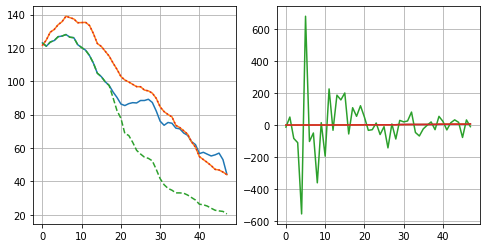

In [36]:
plt.figure(figsize=(8,4))
plt.subplot(121)
for i in range(2): plt.plot(capred2norm[i][0])
plt.plot(casales, '--')
plt.plot(meansales, ':')
plt.grid(which='both')
plt.subplot(122)
for i in range(3): plt.plot(capred2norm[i][1])
plt.plot(cacosts)
plt.grid(which='both')


In [35]:

padl, padr = 0, 0

nc = 0 
xps = []
meanar = []
valar = []
norm = True
pka, pkx = [], []
for ii, dv in enumerate([[salearrayca, casales]]):
    nc +=1
    dd, vv = dv
    xp, means, pk, pkca = setupdata(dd, vv, padl, padr, norm=norm)
    # tfpad = gettfprior(dd, padl, padr)
    # pk = pk/tfpad
    pka.append(pk.mean(axis=0))
    xps.append(xp)
    pkxx = []
    pkx.append([])
    for j in range(len(xps)-1):
        pkx[j].append(psfunc(xps[-1], xps[j]).mean(axis=0))

    meanar.append(means)
    valar.append(vv)

cov2 = np.diag(np.concatenate(pka))
for i in range(len(xps)-1):
    c = np.diag(np.concatenate(pkx[i]), (i+1)*pkx[i][0].size)
    cov2 = cov2 + c+c.T
# #########

print('Minimize')
p0 = np.ones(pkca.size*2*nc)
tomin = lambda p: chisq2d2(p, nc, meanar, valar, cov2, padl, padr, norm=norm)
tomin(p0)
pp = minimize(tomin, p0).x
capred1 = chisq2d2(pp, nc, meanar, valar, cov2, padl, padr, preds=True, norm=norm)



Minimize


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/optimize/linesearch.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)


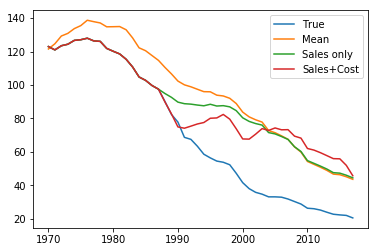

In [39]:
plt.plot(years, casales, label='True')
plt.plot(years, meansales, label='Mean')
plt.plot(years, capred1[0], label='Sales only')
plt.plot(years, capred2[0], label='Sales+Cost')
plt.legend()

In [40]:

# padl, padr = years.size//2, years.size//2
# padl, padr = years.size, years.size
padl, padr = 0, 0

nc = 0 
xps = []
meanar = []
valar = []
norm = 'std'
pka, pkx = [], []
for ii, dv in enumerate([[salearrayca, casales], [costarrayca, cacosts], [pincarrayca, capinc]]):
    nc +=1
    dd, vv = dv
    xp, means, pk, pkca = setupdata(dd, vv, padl, padr, norm=norm)
    # tfpad = gettfprior(dd, padl, padr)
    # pk = pk/tfpad
    pka.append(pk.mean(axis=0))
    xps.append(xp)
    pkxx = []
    pkx.append([])
    for j in range(len(xps)-1):
        pkx[j].append(psfunc(xps[-1], xps[j]).mean(axis=0))

    meanar.append(means)
    valar.append(vv)

cov2 = np.diag(np.concatenate(pka))
for i in range(len(xps)-1):
    c = np.diag(np.concatenate(pkx[i]), (i+1)*pkx[i][0].size)
    cov2 = cov2 + c+c.T
# #########

print('Minimize')
p0 = np.ones(pkca.size*2*nc)
tomin = lambda p: chisq2d2(p, nc, meanar, valar, cov2, padl, padr, norm=norm)
tomin(p0)
pp = minimize(tomin, p0).x
capred3 = chisq2d2(pp, nc, meanar, valar, cov2, padl, padr, preds=True, norm=norm)



ValueError: too many values to unpack (expected 4)

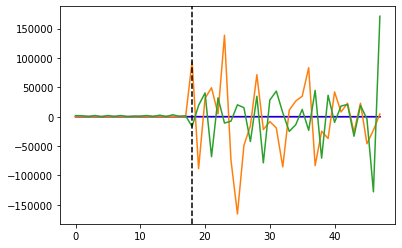

In [39]:
plt.plot(casales, 'r')
plt.plot(meansales, 'b')
# plt.plot(capred1[0], 'C0')
plt.plot(capred2[0], 'C1')
plt.plot(capred3[0], 'C2')
plt.axvline(i1, ls='--', color='k')

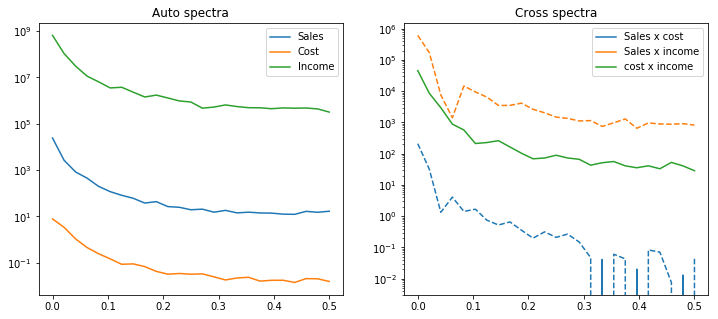

In [312]:
ff = getf(0, 0)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(ff, pka[0], label='Sales')
plt.plot(ff, pka[1], label='Cost')
plt.plot(ff, pka[2], label='Income')
plt.yscale('log')
plt.title('Auto spectra')
plt.legend()
plt.subplot(122)
plt.plot(ff, pkx[0][0], 'C0', label='Sales x cost')
plt.plot(ff, -pkx[0][0], 'C0--')
# plt.plot(ff, -pss12.mean(axis=0), 'k:', lw=2)
plt.plot(ff, pkx[0][1], 'C1', label='Sales x income')
plt.plot(ff, -pkx[0][1], 'C1--')
# plt.plot(ff, -pss13.mean(axis=0), 'k:', lw=2)
plt.plot(ff, pkx[1][0], 'C2', label='cost x income')
plt.plot(ff, -pkx[1][0], 'C2--')
plt.yscale('log')
plt.title('Cross spectra')
plt.legend()


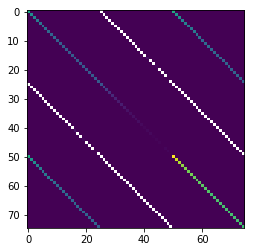

In [316]:
plt.imshow(cov2, norm=LogNorm())


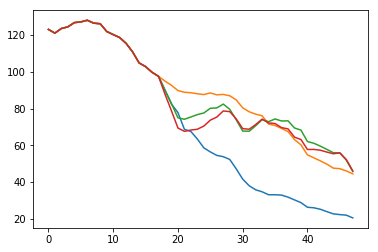

# Non gauss

Expected difference :  [31.60366728]


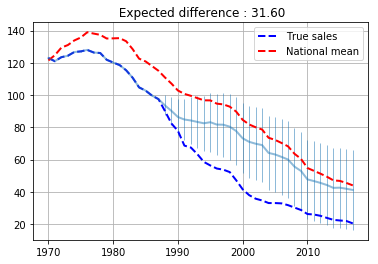

In [649]:
ii = 0 
preds = []
padl, padr = years.size//2, years.size//2

xp, means, pk, pkca = setupdata(salearrayca, casales, padl, padr)
pkm = pk.mean(axis=0)
ffpad  = getf(padl, padr)
tfpad = gettfprior(salearrayca, padl, padr)
pktrue = pkm/tfpad

p0 = np.ones(pkm.size*2)
tomin = lambda p: chisq(p, means, casales, pktrue, padl)
pp = minimize(tomin, p0).x
capred = pred(pp, means)

cov = getcov(pktrue, padl, padr)
err = cov.diagonal()**0.5
preds.append([capred, err])

# if padr: plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1, label='Predict\n(padratio=%.2f)'%(2*padl/yy))
# else: plt.errorbar(years, capred[padl:], err[padl:], alpha=0.5, lw=2, elinewidth=1, label=ii)

plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1)
print('Expected difference : ', capred[padl:-padr][years==2000] - casales[years==2000])
plt.title(' Expected difference : %.2f'%(capred[padl:-padr][years==2000] - casales[years==2000]))
    
plt.plot(years, casales, 'b--', lw=2, label='True sales')
plt.plot(years, meansales, 'r--', lw=2, label='National mean')
plt.grid()
plt.legend()

capredfid = capred.copy()
errfid = err.copy()
# plt.xlim(years[i1], years[-1])
# plt.ylim(20, 100)

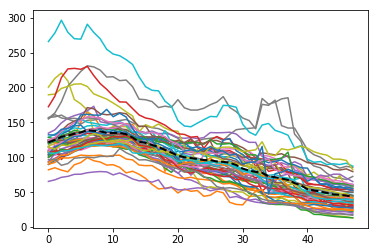

In [111]:
plt.plot(salearray.T)
plt.plot(salearray.mean(axis=0), 'k', ls="--", lw=2)

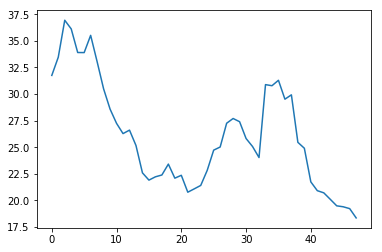

In [112]:
plt.plot(salearray.std(axis=0))

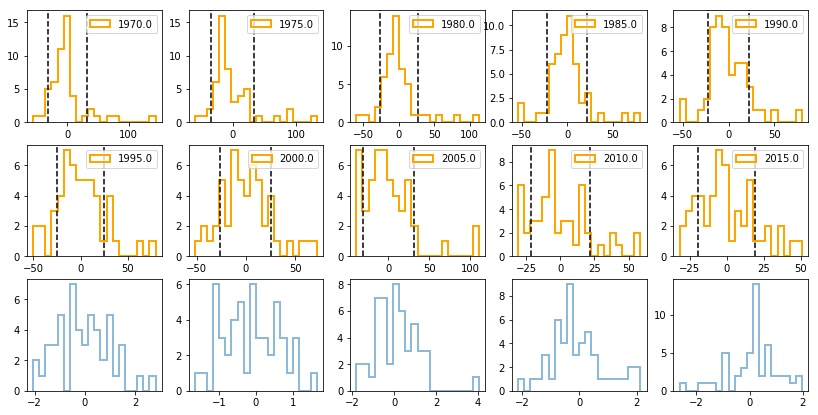

In [113]:
fig, ax = plt.subplots(3, 5, figsize=(14, 7))
for i in range(0, 50, 5):
    axis = ax.flatten()[i//5]
    axis.hist((salearray-salearray.mean(axis=0))[:, i], histtype='step', label=years[i], lw=2, bins=20, color='orange')
    axis.axvline(salearray.std(axis=0)[i], color='k', ls="--")
    axis.axvline(-salearray.std(axis=0)[i], color='k', ls="--")
    axis.legend()

for i in range(5):
    ax[-1, i].hist(np.random.normal(size=50), bins=20, alpha=0.5, histtype='step', lw=2)
plt.show()


Text(0.5, 1.0, '$\\sigma$')

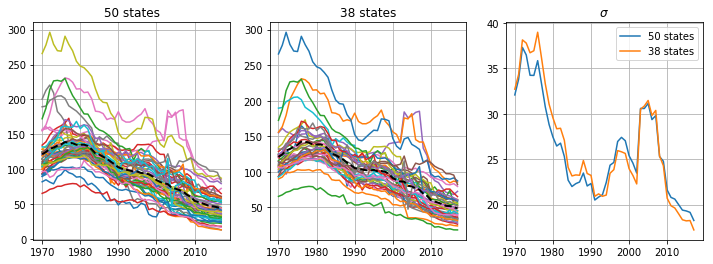

In [308]:
plt.figure(figsize = (12, 4))
plt.subplot(131)
plt.plot(years, salearrayca.T)
plt.plot(years, salearrayca.mean(axis=0), 'k--', lw=2)
plt.grid()
plt.title('50 states')
plt.subplot(132)
plt.plot(years, salearrayskip.T)
plt.plot(years, salearrayskip.mean(axis=0), 'k--', lw=2)
plt.grid()
plt.title('38 states')
plt.subplot(133)
plt.plot(years, salearrayca.std(axis=0), label='50 states')
plt.plot(years, salearrayskip.std(axis=0), label='38 states')
plt.grid()
plt.legend()
plt.title('$\sigma$')

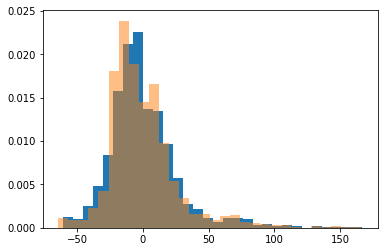

In [220]:
normed = True
nbins = 30

plt.hist((salearray - salearray.mean(axis=0)).flatten(), bins=nbins, normed=normed)
plt.hist((salearrayskip - salearrayskip.mean(axis=0)).flatten(), bins=nbins, normed=normed, alpha=0.5)
plt.show()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  del sys.path[0]


mu=-0.00, s=19.46
mu=0.00, s=0.21
mu=0.00, s=0.77
mu=-0.04, s=0.19


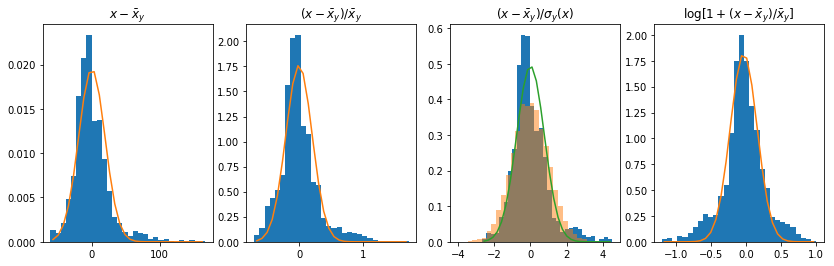

In [684]:
from scipy.optimize import curve_fit as cf
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

def gauss(x, a, mu, s):
# def gauss(x, p):
#     a, mu, s = p
    norm = 1/np.sqrt(2*np.pi*s**2)
#     norm = 1
    return a*norm*np.exp(-0.5*((x-mu)/s)**2)

def fitgauss(xx, bins, normed):
    h, x = np.histogram(xx, bins=nbins, normed=normed)
    x = x[1:] + x[:-1]
    x /= 2 
    p0 = [h.max(), xx.mean(), xx.std()]
    ftomin = lambda p: ((gauss(x, *p) - h)**2).sum()
    pp = minimize(ftomin, p0, method='Nelder-Mead', options={'maxiter':5000})
    print('mu=%.2f, s=%.2f'%(pp.x[1],pp.x[2]))
#     pp = cf(gauss, x, h, p0, )[0]
    return (x, gauss(x, *pp.x))
#     return (x, gauss(x, *pp))


normed = True
nbins = 30
fsize = 12
d = salearrayca.copy()
ni = 4
plt.figure(figsize = (14, 4))
plt.subplot(1, ni, 1)
plt.hist((d - d.mean(axis=0)).flatten(), bins=nbins, normed=normed)
tx, ty = fitgauss((d - d.mean(axis=0)).flatten(), bins=nbins, normed=normed)
plt.plot(tx, ty)
plt.title(r'$x-\bar{x}_y$', fontsize=fsize)

plt.subplot(1, ni, 2)
plt.hist(((d - d.mean(axis=0))/d.mean(axis=0)).flatten(), bins=nbins, normed=normed)
tx, ty = fitgauss(((d - d.mean(axis=0))/d.mean(axis=0)).flatten(), bins=nbins, normed=normed)
plt.plot(tx, ty)
plt.title(r'$(x-\bar{x}_y)/\bar{x}_y$', fontsize=fsize)

plt.subplot(1, ni, 3)
plt.hist(((d - d.mean(axis=0))/d.std(axis=0)).flatten(), bins=nbins, normed=normed)
plt.hist(np.random.normal(size=10000), bins=nbins, normed=normed, alpha=0.5)
tx, ty = fitgauss(((d - d.mean(axis=0))/d.std(axis=0)).flatten(), bins=nbins, normed=normed)
plt.plot(tx, ty)
plt.title(r'$(x-\bar{x}_y)/\sigma_y(x)$', fontsize=fsize)

plt.subplot(1, ni, 4)
plt.hist(np.log(1+(d - d.mean(axis=0))/d.mean(axis=0)).flatten(), bins=nbins, normed=normed)
tx, ty = fitgauss(np.log(1+(d - d.mean(axis=0))/d.mean(axis=0)).flatten(), bins=nbins, normed=normed)
plt.plot(tx, ty)
plt.title(r'log[$1+(x-\bar{x}_y)/\bar{x}_y$]', fontsize=fsize)


plt.show()

### Transformations

In [652]:
def trans(z, eps, eta=1, sig=1, inv=False):
    if inv: 
        if eta  == 0: return z
        x = z*eta
        x =np.arcsinh(x)
        x /= eta
        x *= eps
        x +=1
        x = np.log(x)
        x /= sig
        x /= eps
        return x
    else: 
        if eta == 0: return z
        return np.sinh(eta*((np.exp(sig*eps*z) - 1)/eps))/eta


1.1609249114990234 2.71128511428833
mu=0.00, s=0.77

mu=-0.10, s=0.35
2.659985065460205 12.71702111811534


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  del sys.path[0]


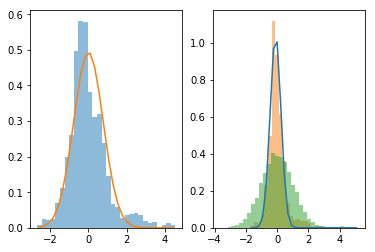

In [722]:
d = salearrayca.copy()
dd = (d - d.mean(axis=0)).flatten()
dz = ((d - d.mean(axis=0))/d.std(axis=0)).flatten()
# plt.hist(dz)
plt.subplot(121)
print(skew(dz), kurtosis(dz))
plt.hist(dz, alpha=0.5, bins=nbins, normed=normed)
tx, ty = fitgauss(dz, bins=nbins, normed=normed)
plt.plot(tx, ty)


plt.subplot(122)
# plt.hist(np.random.normal(size=1000), normed=True, alpha=0.2)
# plt.hist(trans(dz, eps=1, eta=1, sig=1), alpha=0.5, normed=True)
# plt.hist(trans(dz, eps=1, eta=1, sig=.1), alpha=0.5, normed=True)

print('')
# yy = trans(dz, eps=.01, eta=1, sig=.2)
yy = trans(dz, eps=.03, eta=1, sig=.5)
tx, ty = fitgauss(yy, bins=nbins, normed=normed)
plt.plot(tx, ty)
print(skew(yy), kurtosis(yy))
plt.hist(yy, alpha=0.5, bins=nbins, normed=normed)
plt.hist(np.random.normal(size=10000), alpha=0.5, bins=nbins, normed=normed)


# yy = trans(dz, eps=1, eta=1, sig=.3)
# tx, ty = fitgauss(yy, bins=nbins, normed=normed)
# plt.plot(tx, ty)
# print(skew(yy), kurtosis(yy))
# plt.hist(yy, alpha=0.5, bins=nbins, normed=normed)

plt.show()

 final_simplex: (array([[-1.35480881e-03,  1.36580505e+00],
       [-1.34170151e-03,  1.36576843e+00],
       [-1.34829974e-03,  1.36590328e+00]]), array([0.32640769, 0.32640769, 0.32640769]))
           fun: 0.3264076942507041
       message: 'Optimization terminated successfully.'
          nfev: 51
           nit: 23
        status: 0
       success: True
             x: array([-1.35480881e-03,  1.36580505e+00])
0.060833333333333336


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the b

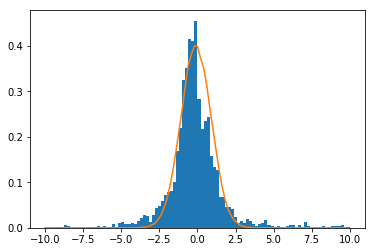

In [729]:
normhist = np.histogram(np.random.normal(size=100000), bins=100, normed=True, range=(-10, 10))
d = salearrayca.copy()
dz = ((d - d.mean(axis=0))/d.std(axis=0)).flatten()
# stdmean = salearrayca.std(axis=0).mean()
# dz = ((d - d.mean(axis=0))/stdmean).flatten()

def fithist(p, z, normhist):
    eps, sig = p
    h, x = normhist
    dzt = trans(dz, eps=eps, sig=sig)
    hy, _ = np.histogram(dzt, bins=x, normed=True )
    return h, hy

def tomin(p):
    hx, hy = fithist(p, dz, normhist)
#     print(sum((hx-hy)**2))
    return sum((hx-hy)**2)**0.5
    
    
# pp = minimize(tomin, [0.03, 0.5], method='Nelder-Mead')
pp = minimize(tomin, [0, 1], method='Nelder-Mead')
print(pp)
print((trans(dz, eps=pp.x[0], sig=pp.x[1]) > 5).sum()/dz.size)

# plt.hist(trans(dz, eps=pp.x[0], sig=pp.x[1]), bins=20, normed=True, alpha=0.5)
yy = trans(dz, eps=pp.x[0], sig=pp.x[1])
plt.hist(yy, bins=normhist[1], normed=True)
# tx, ty = fitgauss(yy, bins=normhist[1], normed=normed)
# plt.plot(tx, ty)
plt.plot(normhist[1][:-1], normhist[0])

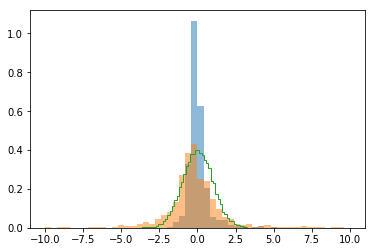

In [741]:
eta = 1 
norm = 'std'
for ii, tp in enumerate([[0.03, 0.5], [pp.x[0], pp.x[1]]]):
    eps, sig = tp[0], tp[1]
    lambtrans = lambda z: trans(z, eps=eps, eta=eta, sig=sig)
    lambitrans = lambda z: trans(z, eps=eps, eta=eta, sig=sig,  inv=True)

    ii = 0 
    preds = []
    padl, padr = years.size//2, years.size//2
    # padl, padr = 0, 0

    xp, means, pk, pkca, sstd = setupdata(salearrayca, casales, padl, padr, trans=lambtrans, norm=norm)
    plt.hist(xp[:, padl:-padr].flatten(), alpha=0.5, bins=50, normed=True, range=(-10, +10))
plt.hist(np.random.normal(size=10000), histtype='step', bins=50, normed=True)
plt.show()


In [743]:

eta = 1 
for ii, tp in enumerate([[0.03, 0.5], [pp.x[0], pp.x[1]]]):
    eps, sig = tp[0], tp[1]/stdmean
    lambtrans = lambda z: trans(z, eps=eps, eta=eta, sig=sig)
    lambitrans = lambda z: trans(z, eps=eps, eta=eta, sig=sig,  inv=True)

    ii = 0 
    preds = []
    padl, padr = years.size//2, years.size//2
    # padl, padr = 0, 0

    xp, means, pk, pkca, sstd = setupdata(salearrayca, casales, padl, padr, trans=lambtrans, norm=norm)
    pkm = pk.mean(axis=0)
    ffpad  = getf(padl, padr)
    tfpad = gettfprior(salearrayca, padl, padr, trans=lambtrans)
    pktrue = pkm/tfpad

    p0 = np.ones(pkm.size*2)
    tomin = lambda p: chisq(p, means*0, lambtrans(casales-means[padl:-padr]), pktrue, padl, sigma=1, norm=sstd)
    pmin = minimize(tomin, p0).x
    capredt = pred(pmin, means*0, norm=norm)
    capred = lambitrans(capredt) + means

    cov = getcov(pktrue, padl, padr, n0=1e-1)

    errt = cov.diagonal()**0.5
    dfdx = (lambitrans(capredt*1.001) - lambitrans(capredt*0.999))/(capredt*0.002)
    err = errt*dfdx

    # plt.errorbar(years, capred[padl:-padr], err[padl:-padr], alpha=0.5, lw=2, elinewidth=1)
    plt.errorbar(years, capred[padl:-padr], alpha=0.5, lw=2, elinewidth=1)
    print('Expected difference : ', capred[padl:-padr][years==2000] - casales[years==2000])
# plt.title(' Expected difference : %.2f'%(capred[padl:-padr][years==2000] - casales[years==2000]))
    
plt.errorbar(years, capredfid[padl:-padr], errfid[padl:-padr], alpha=0.5, lw=2, elinewidth=1, marker='x', label='Fid')
plt.plot(years, casales, 'b--', lw=2, label='True sales')
plt.plot(years, meansales, 'r--', lw=2, label='National mean')
plt.grid()
plt.legend()

# plt.xlim(years[i1], years[-1])
# plt.ylim(20, 100)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [711]:
er

array([ 0.31621601,  0.31620513,  0.31620497,  0.31620266,  0.31619529,
        0.31619346,  0.31619346,  0.31619272,  0.31619123,  0.31619079,
        0.31619079,  0.31619067,  0.31619047,  0.31619041,  0.3161904 ,
        0.31619039,  0.31619031,  0.31619026,  0.31619027,  0.31619027,
        0.31619026,  0.31619026,  0.31619027,  0.31619027,  0.31619026,
        0.31619031,  0.31619039,  0.3161904 ,  0.31619041,  0.31619047,
        0.31619067,  0.31619079,  0.31619079,  0.31619123,  0.31619272,
        0.31619346,  0.31619346,  0.31619529,  0.31620266,  0.31620497,
        0.31620513,  0.31621601, 36.67576667, 50.89655597, 58.87801144,
       59.41945207, 61.96964592, 64.08167223, 66.75132155, 67.70416432,
       68.08808358, 68.27118036, 68.41650756, 68.57909998, 68.63366651,
       68.67151188, 68.69125378, 68.72280018, 68.72546518, 68.72684329,
       68.72651492, 68.72989894, 68.72460628, 68.71695983, 68.71455395,
       68.7101329 , 68.7103406 , 68.71186267, 68.7143322 , 68.71

In [671]:
(abs(xp[xp!=0]) > 5).sum()/(xp!=0).sum()

0.06833333333333333

[]

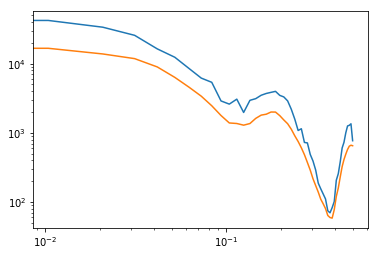

In [698]:
plt.plot(ffpad, pktrue)
plt.plot(ffpad, pkm)
plt.loglog()